# T-S diagrams from TAO & Argo at (0, 145W→135W)

In this notebook 140W really means (145W → 135W)

looking at TS diagrams across latitudes. 

1. During TIW activity do we see more stirring near the equator or off the equator?
2. If salinity is a minor contributor to density, do we really expect to see T-S scatter as a signal of eddy stirring?

(Surprising conclusions)

1. T-S spread is similar in all ENSO phases. There is some separation in temperature (as expected)
2. Latitudinal variation in T-S spread is big; but again ENSO variation is minimal at all latitudes I've checked.

In [6]:
%load_ext watermark

import cf_xarray
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xfilter
import xgcm
import xhistogram

import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)

%watermark -iv
plt.rcParams["figure.dpi"] = 180
plt.rcParams["savefig.dpi"] = 200

plt.style.use("bmh")
client.close()
client = distributed.Client(n_workers=3, processes=False, memory_limit="8GB")
client

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas     : 1.2.3
xfilter    : 0.1.dev41+geb0277f
xgcm       : 0.5.1
cf_xarray  : 0.4.1.dev21+gab9dc66
dcpy       : 0.1
numpy      : 1.20.2
eddydiff   : 0.1
pump       : 0.1
distributed: 2021.4.0
xhistogram : 0.1.3+31.g2681aee
matplotlib : 3.4.1
xarray     : 0.17.1.dev3+g48378c4b1



<Client: 'inproc://192.168.0.10/1804444/1' processes=3 threads=9, memory=22.35 GiB>

## TIWKE from TAO

In [7]:
tao = xr.open_zarr(
    "/home/deepak/work/pump/notebooks/tao_eq_hr_gridded.zarr/", consolidated=True
).sel(longitude=-140, time=slice("1996", None))

vmean = (
    tao.v.sel(depth=slice(-80, 0))
    .mean("depth")
    .chunk({"time": -1})
    .interpolate_na("time", max_gap="10D")
    .compute()
)

# Moum et al. 2009 metric
v = xfilter.bandpass(
    vmean,
    "time",
    freq=[1 / 12, 1 / 33],
    cycles_per="D",
    debug=False,
    num_discard=120,
)
tiwke = xfilter.lowpass(
    v ** 2 / 2,
    "time",
    freq=1 / 20,
    cycles_per="D",
)
tiwke.attrs = {"long_name": "TIW KE", "units": "m²/s²"}
tiwke = tiwke

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Argo

### Read data

In [8]:
ds = xr.open_mfdataset(
    "argo_140_20*_*.nc",
    preprocess=lambda ds: ds.drop_vars("N_POINTS"),
    concat_dim="N_POINTS",
    combine="nested",
).load()
ds.coords["year"] = ds.TIME.dt.year
ds

<xarray.Dataset>
Dimensions:                (N_POINTS: 1327818)
Coordinates:
    LATITUDE               (N_POINTS) float64 6.221 6.221 ... -1.509 -1.509
    LONGITUDE              (N_POINTS) float64 -140.0 -140.0 ... -138.7 -138.7
    TIME                   (N_POINTS) datetime64[ns] 2005-03-08T17:40:05 ... ...
    year                   (N_POINTS) int64 2005 2005 2005 ... 2020 2020 2020
Dimensions without coordinates: N_POINTS
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_POINTS) int64 1 1 1 1 1 1 1 ... 84 84 84 84 84 84
    CYCLE_NUMBER           (N_POINTS) int64 1 1 1 1 1 1 1 ... 84 84 84 84 84 84
    DATA_MODE              (N_POINTS) object 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_POINTS) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_POINTS) int64 5900884 5900884 ... 1902197 1902197
    POSITION_QC            (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_POINTS) float64 34.85 34.85 34.85 ... 34.62 34.62
    PSAL_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_POINTS) float64 27.97 27.97 27.97 ... 7.57 7.555
    TEMP_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/04/08
    Fetched_constraints:  [x=-145.00/-135.00; y=-2.00/8.00; z=0.0/500.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

### Generate ENSO labels

From Anna; Some Trenberth metric


1. Use NINO34 SST annomaly (w.r.t mean from 18xx)
2. At least 6 month long periods of SSTA > 0.4 (El-nino) & SSTA < -0.4 (La-Nina). Neutral everywhere else

In [11]:
from dcpy.util import block_lengths
from xarray.core.missing import _get_nan_block_lengths, get_clean_interp_index

nino34 = pump.obs.process_nino34()
ssta = nino34 - nino34.mean()  # .rolling(time=6, center=True).mean()

enso = xr.full_like(ssta, fill_value="Neutral", dtype="U8")
index = ssta.indexes["time"] - ssta.indexes["time"][0]
en_mask = _get_nan_block_lengths(
    xr.where(ssta > 0.4, np.nan, 0), dim="time", index=index
) >= pd.Timedelta("169d")
ln_mask = _get_nan_block_lengths(
    xr.where(ssta < -0.4, np.nan, 0), dim="time", index=index
) >= pd.Timedelta("169d")
# neut_mask = _get_nan_block_lengths(xr.where((ssta < 0.5) & (ssta > -0.5), np.nan, 0), dim="time", index=index) >= pd.Timedelta("120d")

enso.loc[en_mask] = "El-Nino"
enso.loc[ln_mask] = "La-Nina"
# enso.loc[neut_mask] = "Neutral"

enso.name = "enso_phase"
enso.attrs[
    "description"
] = "ENSO phase; El-Nino = NINO34 SSTA > 0.4 for at least 6 months; La-Nina = NINO34 SSTA < -0.4 for at least 6 months"
enso

<xarray.DataArray 'enso_phase' (time: 1812)>
array(['Neutral', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype='<U8')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-31 1870-02-28 ... 2020-12-31
Attributes:
    description:  ENSO phase; El-Nino = NINO34 SSTA > 0.4 for at least 6 mont...

Test against TIWKE

In [14]:
counts = (
    ds.query({"N_POINTS": "PRES > 35 and PRES < 120"})
    .TEMP.swap_dims({"N_POINTS": "TIME"})
    .resample(TIME="M")
    .count()
)
counts.attrs = {"long_name": "number of Argo samples", "units": "per month"}

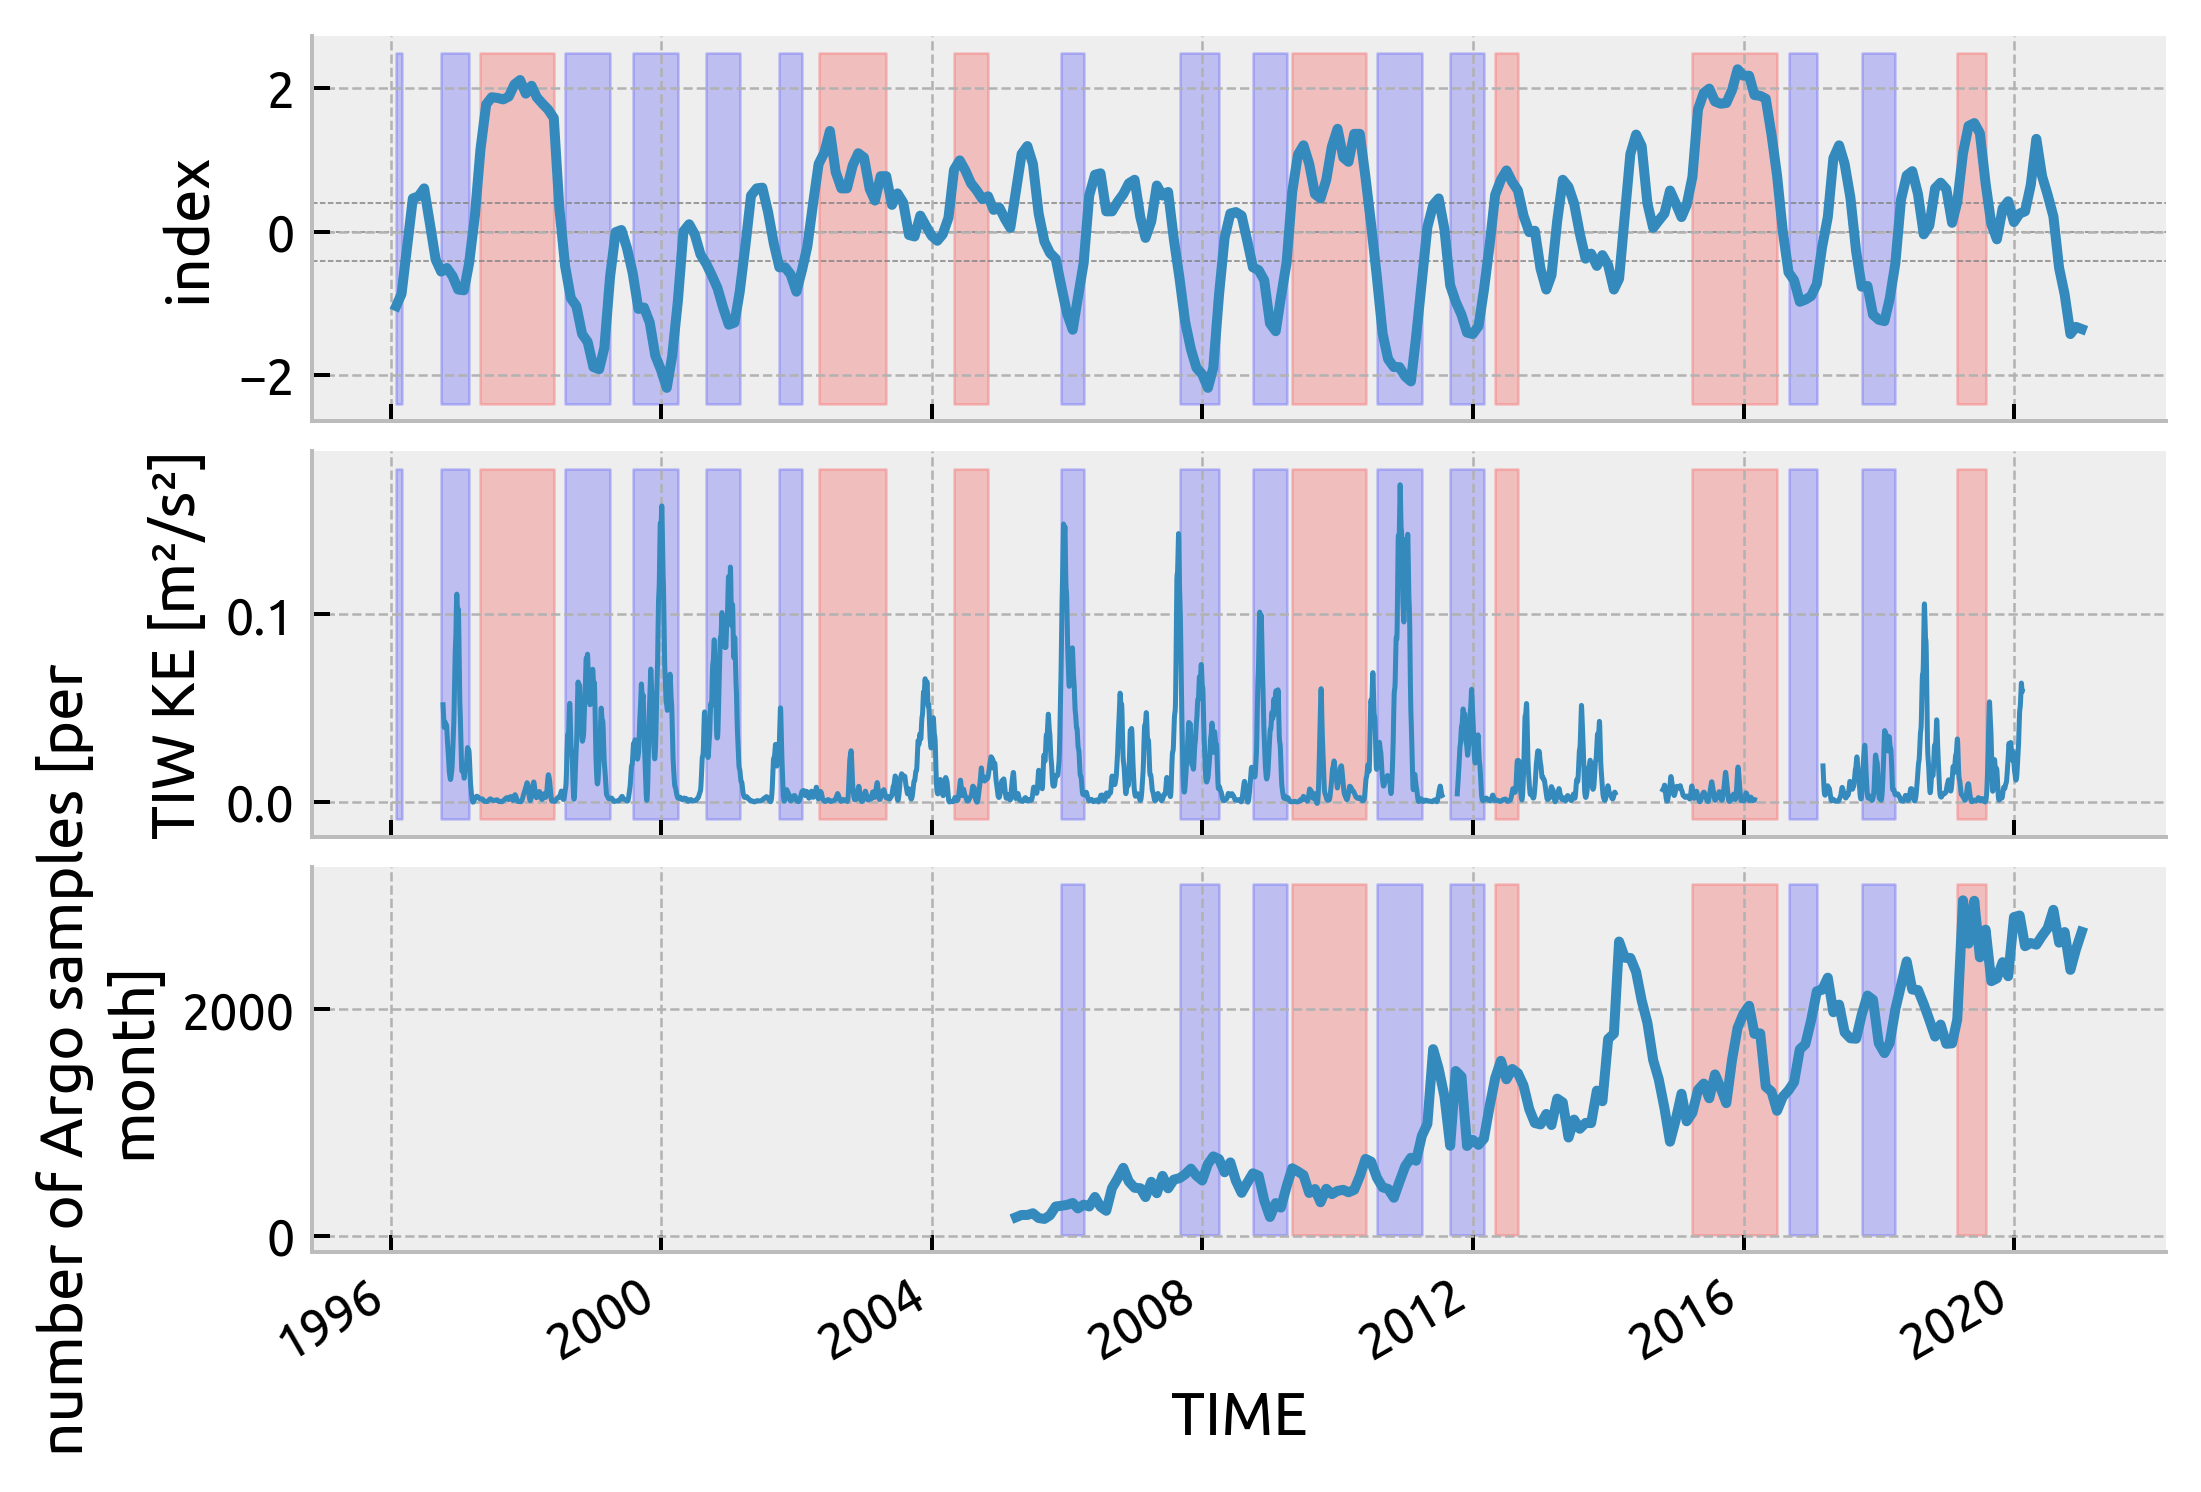

In [15]:
def highlight_enso(ax, enso, coord="time"):
    coord = enso[coord]
    ylim = ax.get_ylim()
    ax.fill_between(
        coord.data,
        ylim[0],
        ylim[1],
        where=enso.data == "El-Nino",
        color="r",
        alpha=0.2,
        zorder=-1,
    )
    ax.fill_between(
        coord.data,
        ylim[0],
        ylim[1],
        where=enso.data == "La-Nina",
        color="b",
        alpha=0.2,
        zorder=-1,
    )


ssta_ = dcpy.util.slice_like(ssta, tiwke)
enso_ = dcpy.util.slice_like(enso, tiwke)

f, axx = plt.subplots(3, 1, sharex=True, constrained_layout=True)
ssta_.plot(x="time", ax=axx[0])
highlight_enso(axx[0], enso_)
dcpy.plots.liney([-0.4, 0, 0.4], ax=axx[0], lw=0.3)

tiwke.plot(ax=axx[1], lw=1)
highlight_enso(axx[1], enso_)

counts.plot(ax=axx[2])
highlight_enso(axx[2], enso_.sel(time=slice("2005", None)))

dcpy.plots.clean_axes(np.atleast_2d(axx).T)

check ENSO phase calculation

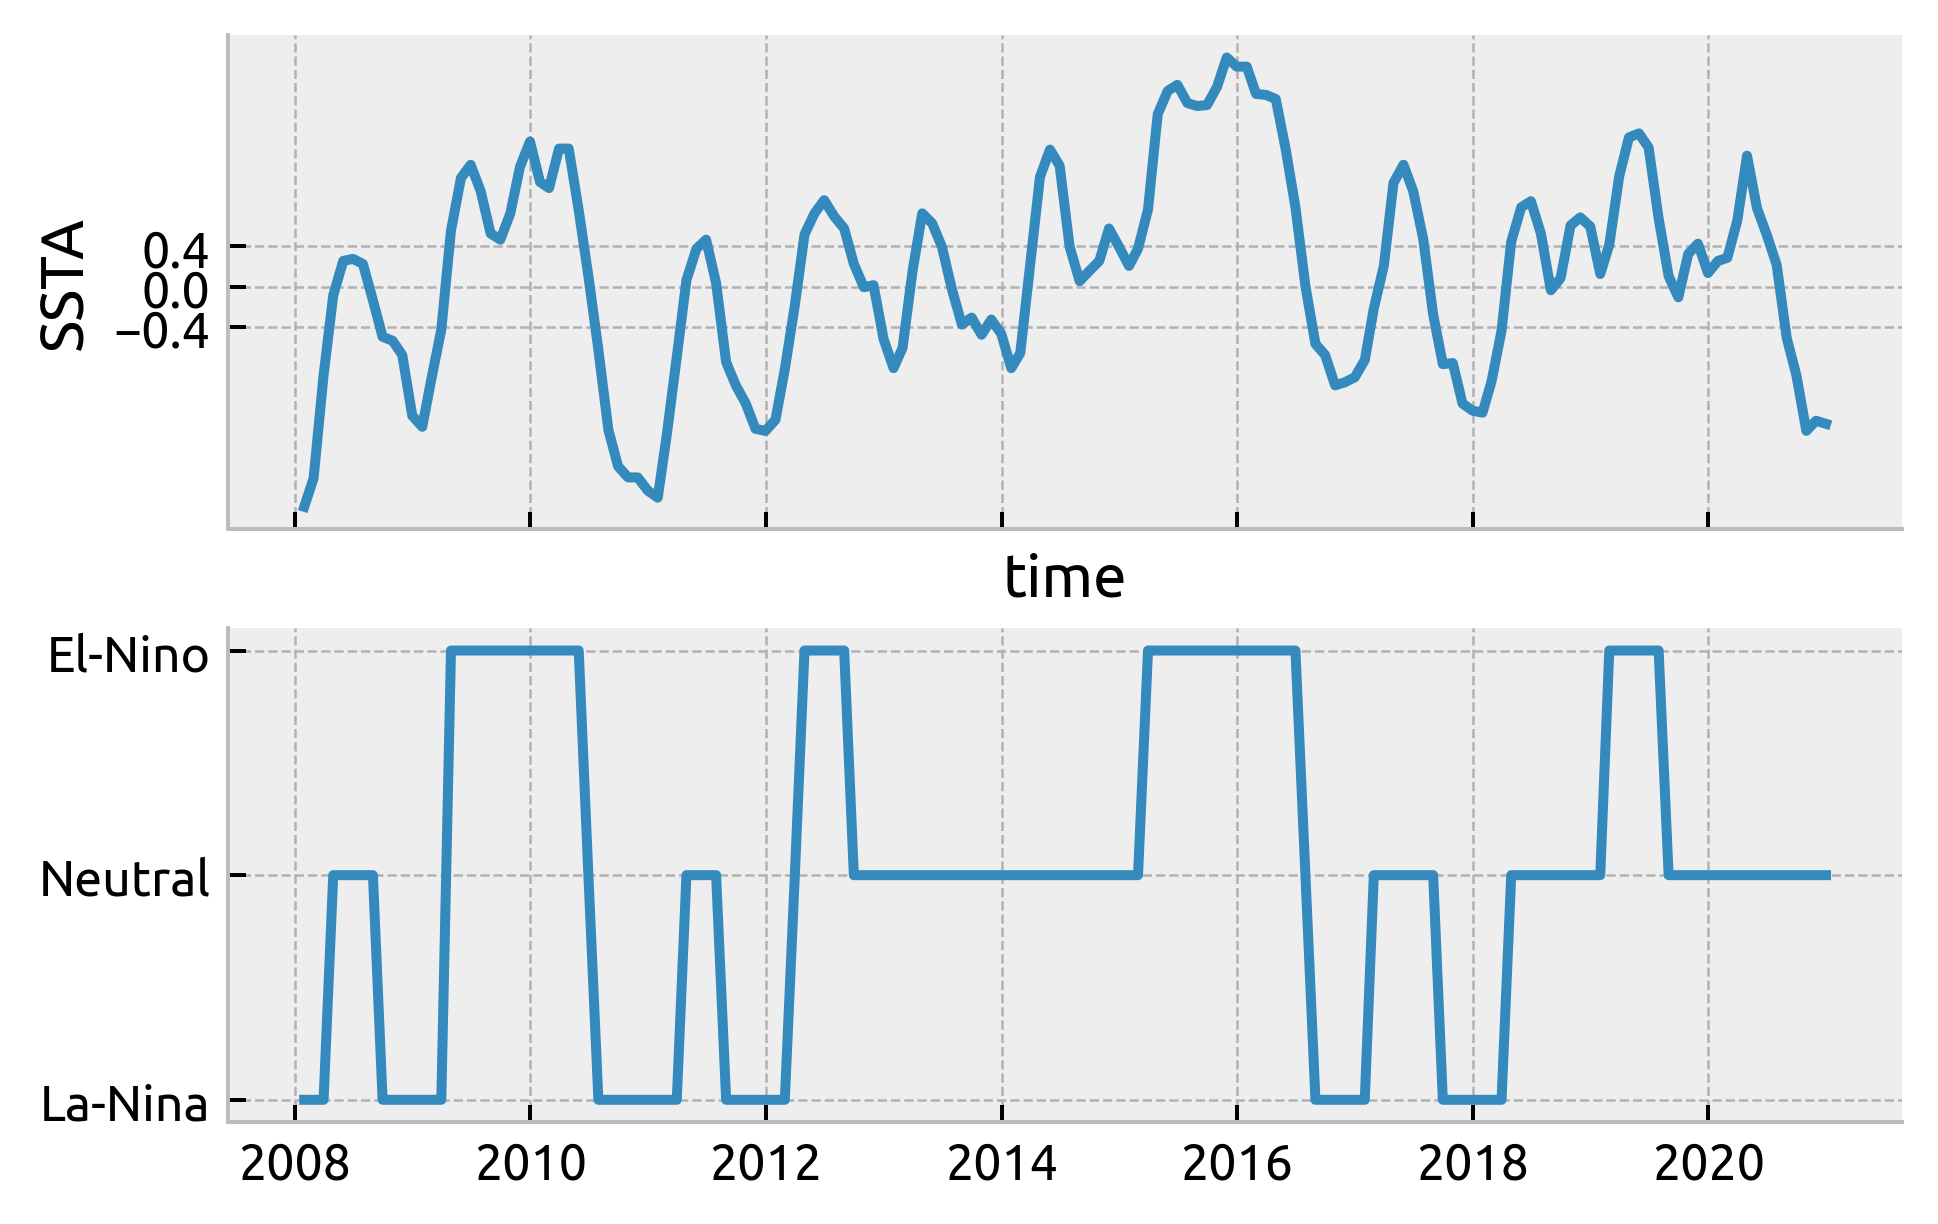

In [16]:
f, ax = plt.subplots(2, 1, sharex=True)
(nino34 - nino34.mean()).sel(time=slice("2008", None)).plot(ax=ax[0])
ax[0].set_ylabel("SSTA")
ax[0].set_yticks([-0.4, 0, 0.4])
plt.plot(enso.time.sel(time=slice("2008", None)), enso.sel(time=slice("2008", None)))

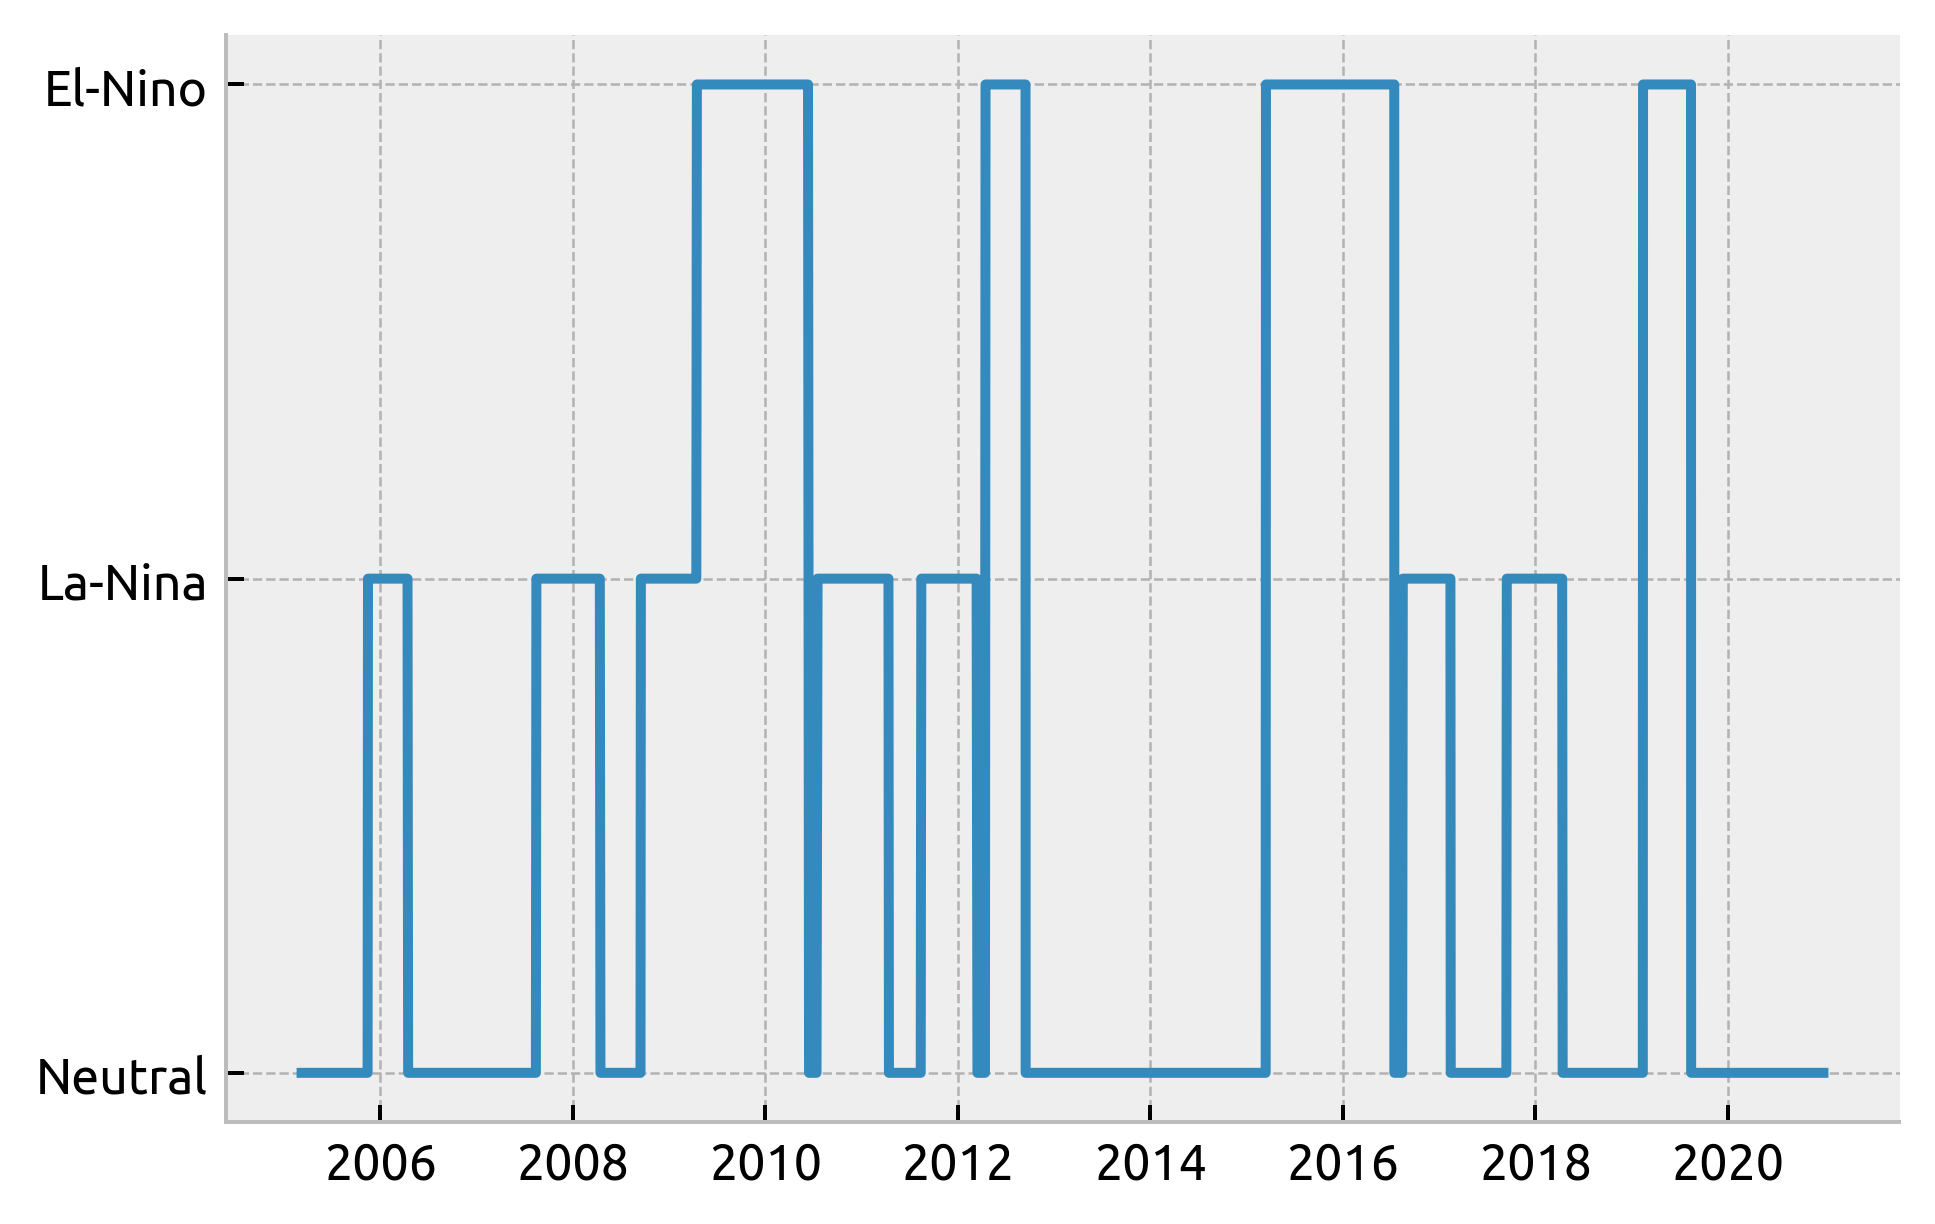

In [17]:
ds.coords["enso_phase"] = enso.sel(time=ds.TIME, method="nearest")
plt.plot(ds.TIME, ds.enso_phase)

## Latitudinal variation at 140W

Text(0.5, 1.0, '2005-2020')

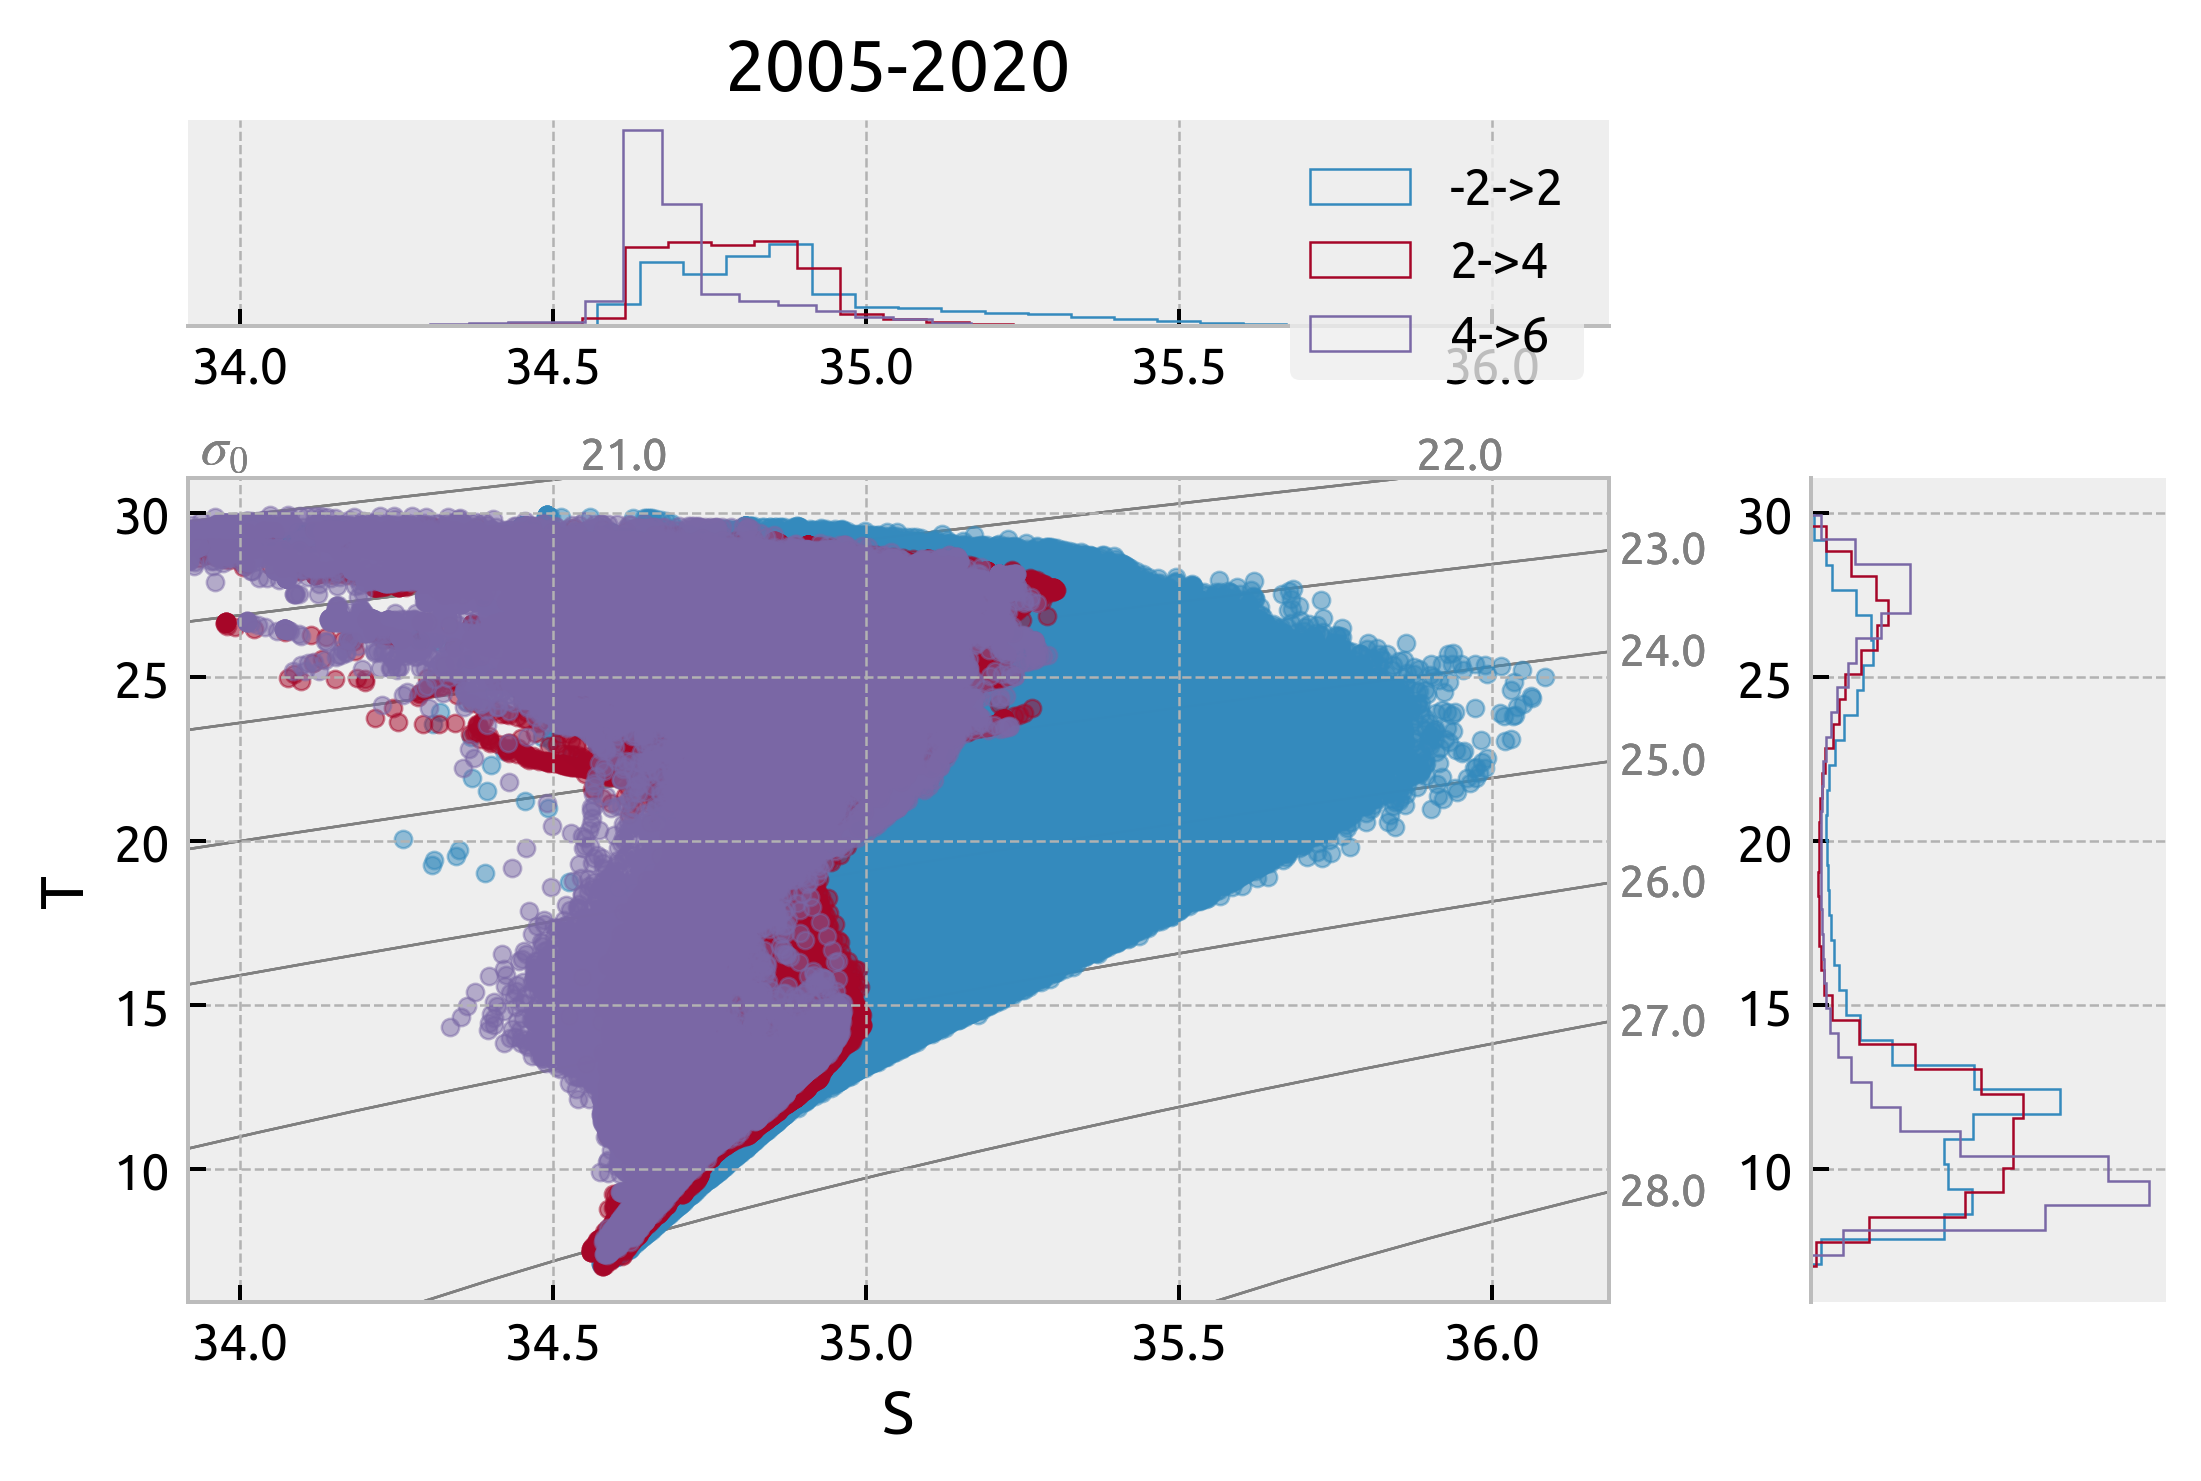

In [18]:
subset = ds.query({"N_POINTS": "LATITUDE > -2 & LATITUDE < 2"})
_, ax = dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False)

subset = ds.query({"N_POINTS": "LATITUDE > 2 & LATITUDE < 4"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

subset = ds.query({"N_POINTS": "LATITUDE > 4 & LATITUDE < 6"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

ax["s"].legend(["-2->2", "2->4", "4->6"])
ax["s"].set_title("2005-2020")

## Interannual variation at (2S→2N, -140)

Picked out two La-Nina(2008, 09; 2012, 13) and one El-Nino period (2015, 2016). They look very similar

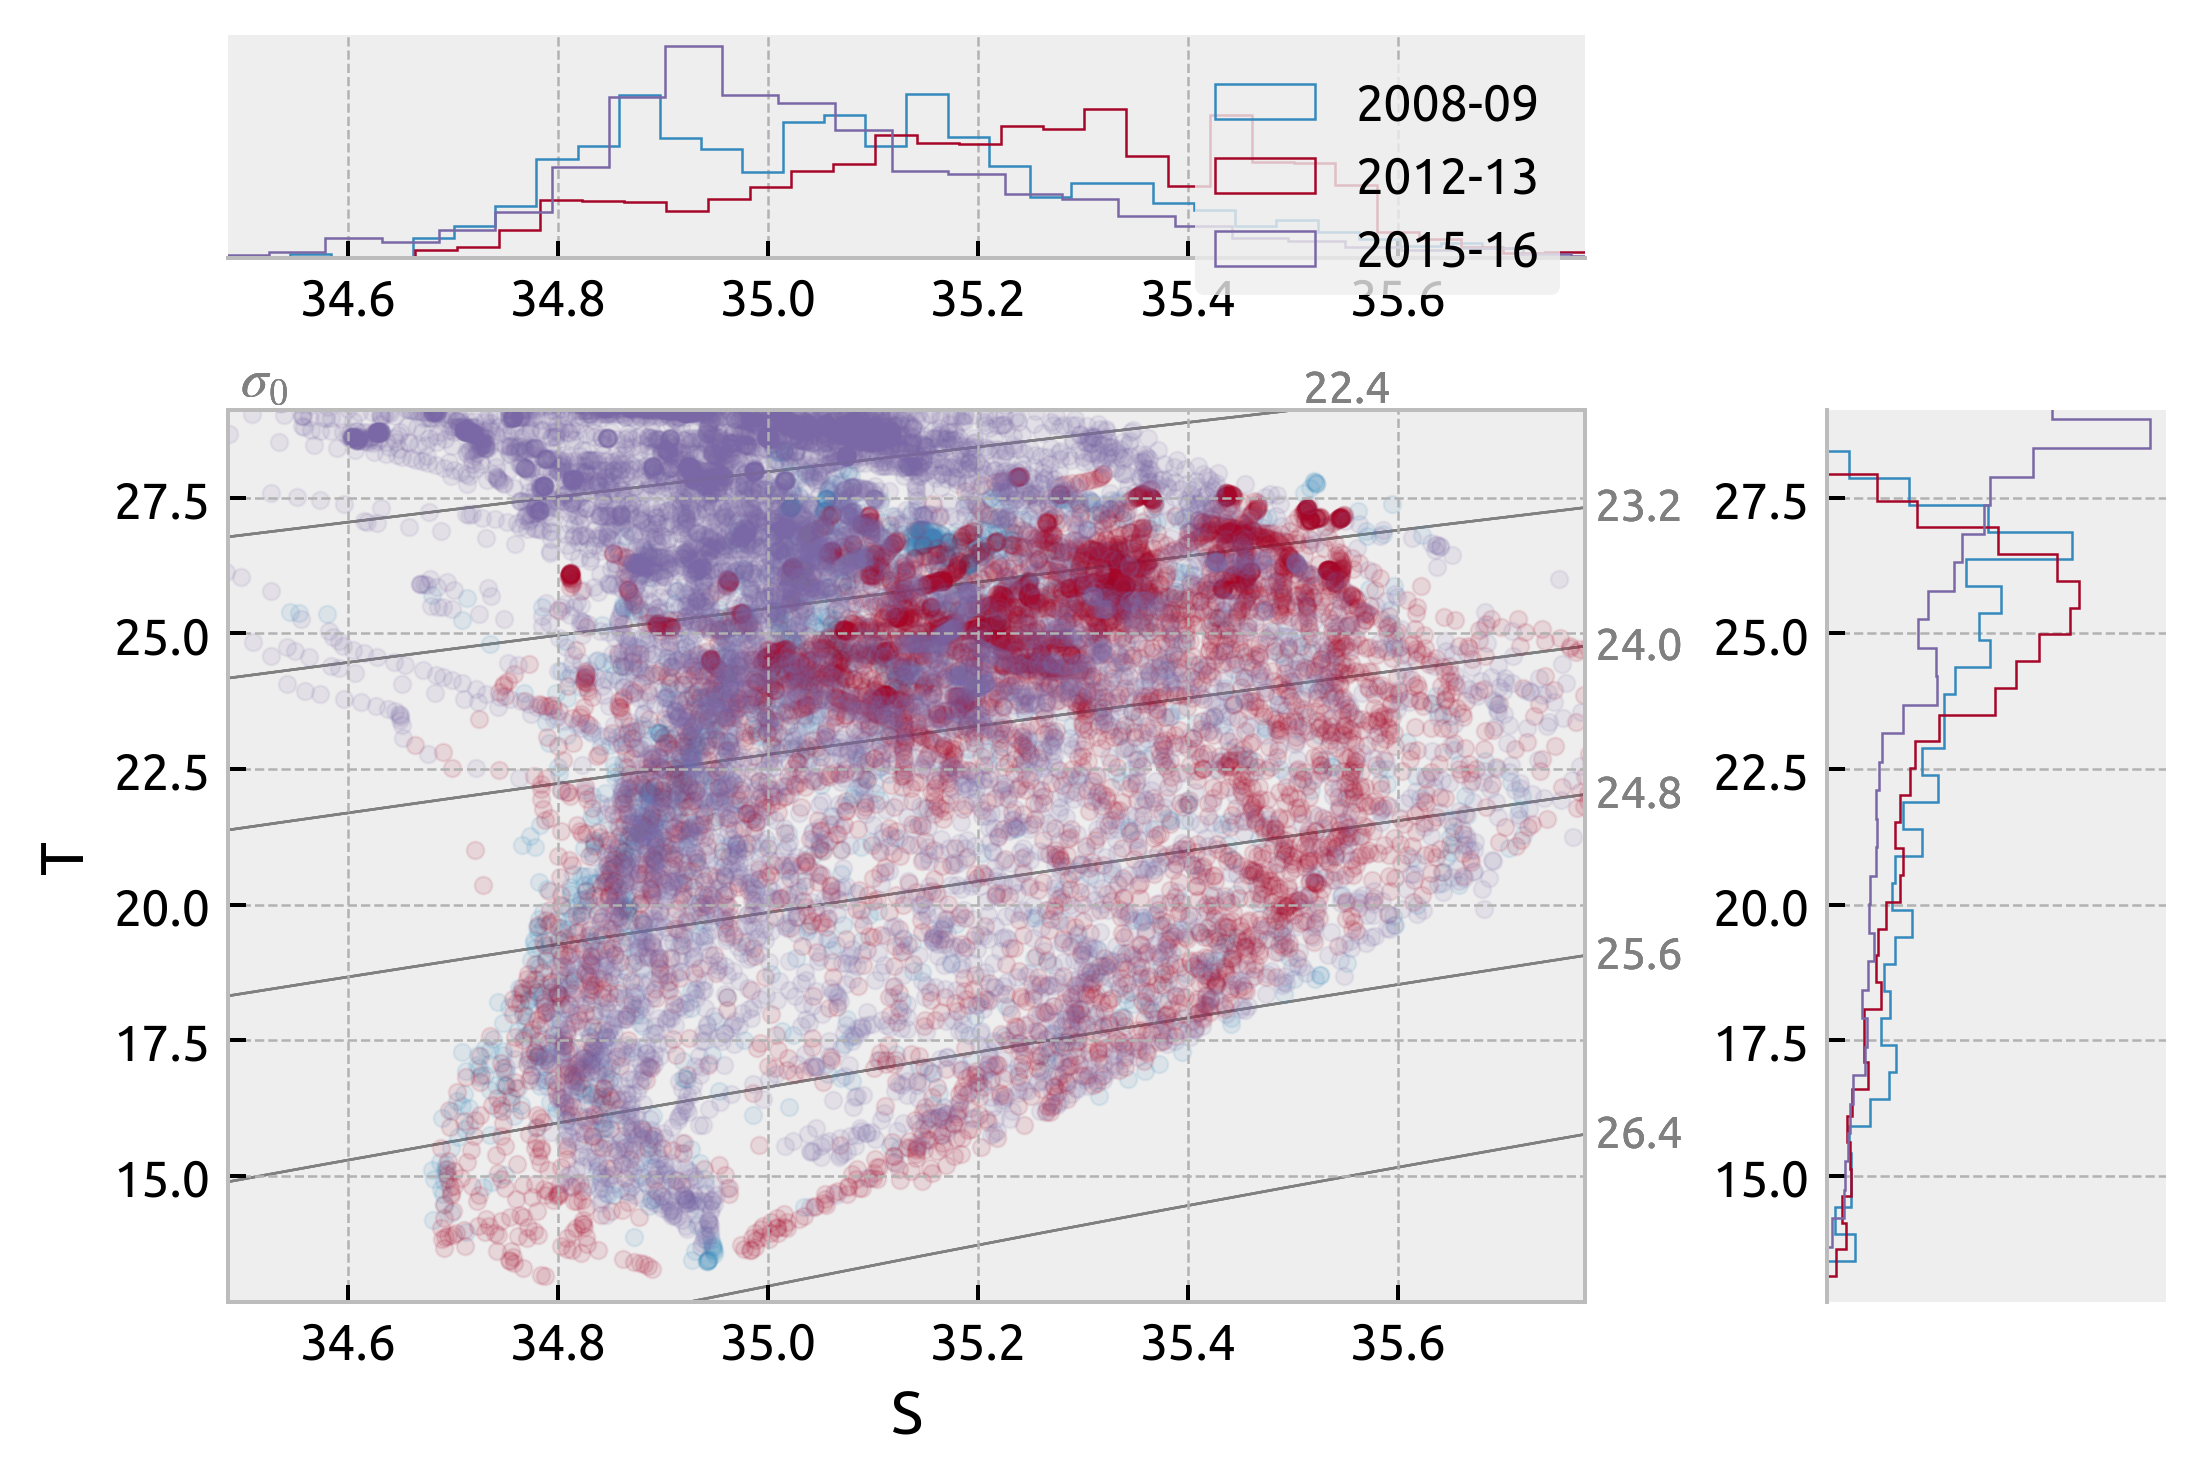

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [55]:
kwargs = dict(kind="scatter", plot_kwargs=dict(alpha=0.1))

common = "LONGITUDE > -142 & LONGITUDE < -138 & LATITUDE > -2 & LATITUDE < 2 & PRES > 35 & PRES < 120"
subset = ds.query({"N_POINTS": f"{common} & (year == 2008 | year == 2009)"})
_, ax = dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, **kwargs)

subset = ds.query({"N_POINTS": f"{common} & (year == 2012 | year == 2013)"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, **kwargs, ax=ax)

subset = ds.query({"N_POINTS": f"{common} & (year == 2015 | year == 2016)"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, **kwargs, ax=ax)

ax["s"].legend(["2008-09", "2012-13", "2015-16"])

## T-S diagram variation with ENSO phase

This is a TS diagram of Argo profiles between 135W→145W, 2S→2N; grouped by ENSO phase.

1. El-Nino:
   - isopycnal scatter at warmer isotherms during El-Ninos (top 100m). Where is that coming from.
   - Below ≈ 100m the TS relationship is tight with two end-members? Some of this is a function of spatial extent.
   
2. La-Nina:
   - Similar scatter to El-Nino which is surprising
   
3. Neutral:
   - Lots of scatter! But also lots more points.
   - higher salinity water appears
   
   
- could add depth contours.

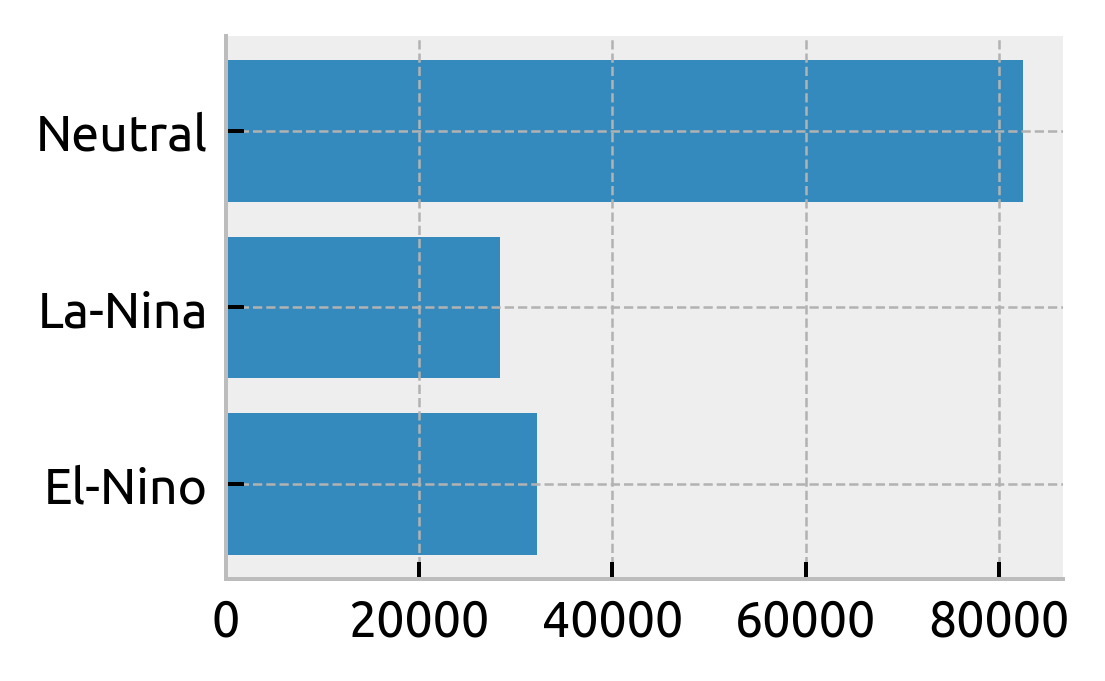

In [31]:
counts = (
    ds.query({"N_POINTS": f"LATITUDE > -2 & LATITUDE < 2 & PRES > 35 & PRES < 120"})
    .groupby("enso_phase")
    .count()
)
plt.barh(counts.enso_phase, counts.TEMP)
plt.gcf().set_size_inches((3, 2))

In [33]:
def plot_TS(latitude_string):
    """ Plot a TS diagram per ENSO phase"""
    from matplotlib.lines import Line2D

    kwargs = dict(
        hexbin=True,
        plot_kwargs={"alpha": 0.3, "mincnt": 10, "norm": mpl.colors.LogNorm(1, 100)},
    )
    kwargs = dict(kind="scatter", plot_kwargs={"alpha": 0.1})
    kwargs = dict(kind="hist", equalize=False, plot_kwargs={"alpha": 0.6})

    ax = None
    labels = []
    lines = []

    for phase, cmap, color in [
        ["El-Nino", mpl.cm.Reds, "red"],
        ["Neutral", mpl.cm.Greys, "black"],
        ["La-Nina", mpl.cm.Blues, "blue"],
    ]:
        subset = ds.query(
            {
                "N_POINTS": f"{latitude_string} & enso_phase == {phase!r} & PRES > 35 & PRES < 100"
            }
        )
        kwargs["plot_kwargs"]["cmap"] = cmap
        if ax is not None:
            kwargs.update({"label_spines": False, "rho_levels": None})

        hdl, ax = dcpy.oceans.TSplot(
            subset.PSAL, subset.TEMP, color=color, **kwargs, ax=ax
        )
        lines.append(Line2D([0], [0], color=color, lw=1))
        labels.append(phase)

    ax["ts"].set_ylim([None, 31])
    ax["t"].get_figure().legend(handles=lines, labels=labels, loc="upper right")
    ax["s"].set_title(latitude_string)

It looks like there is latitudinal variation in T-S spread along isopycnals but not really an ENSO phase variation. The La-Nina and Neutral TS diagrams basically overlap but we can see that the La-Nina and El-Nino diagrams are really only different in that the El-Nino one is warmer. The spread looks the same.

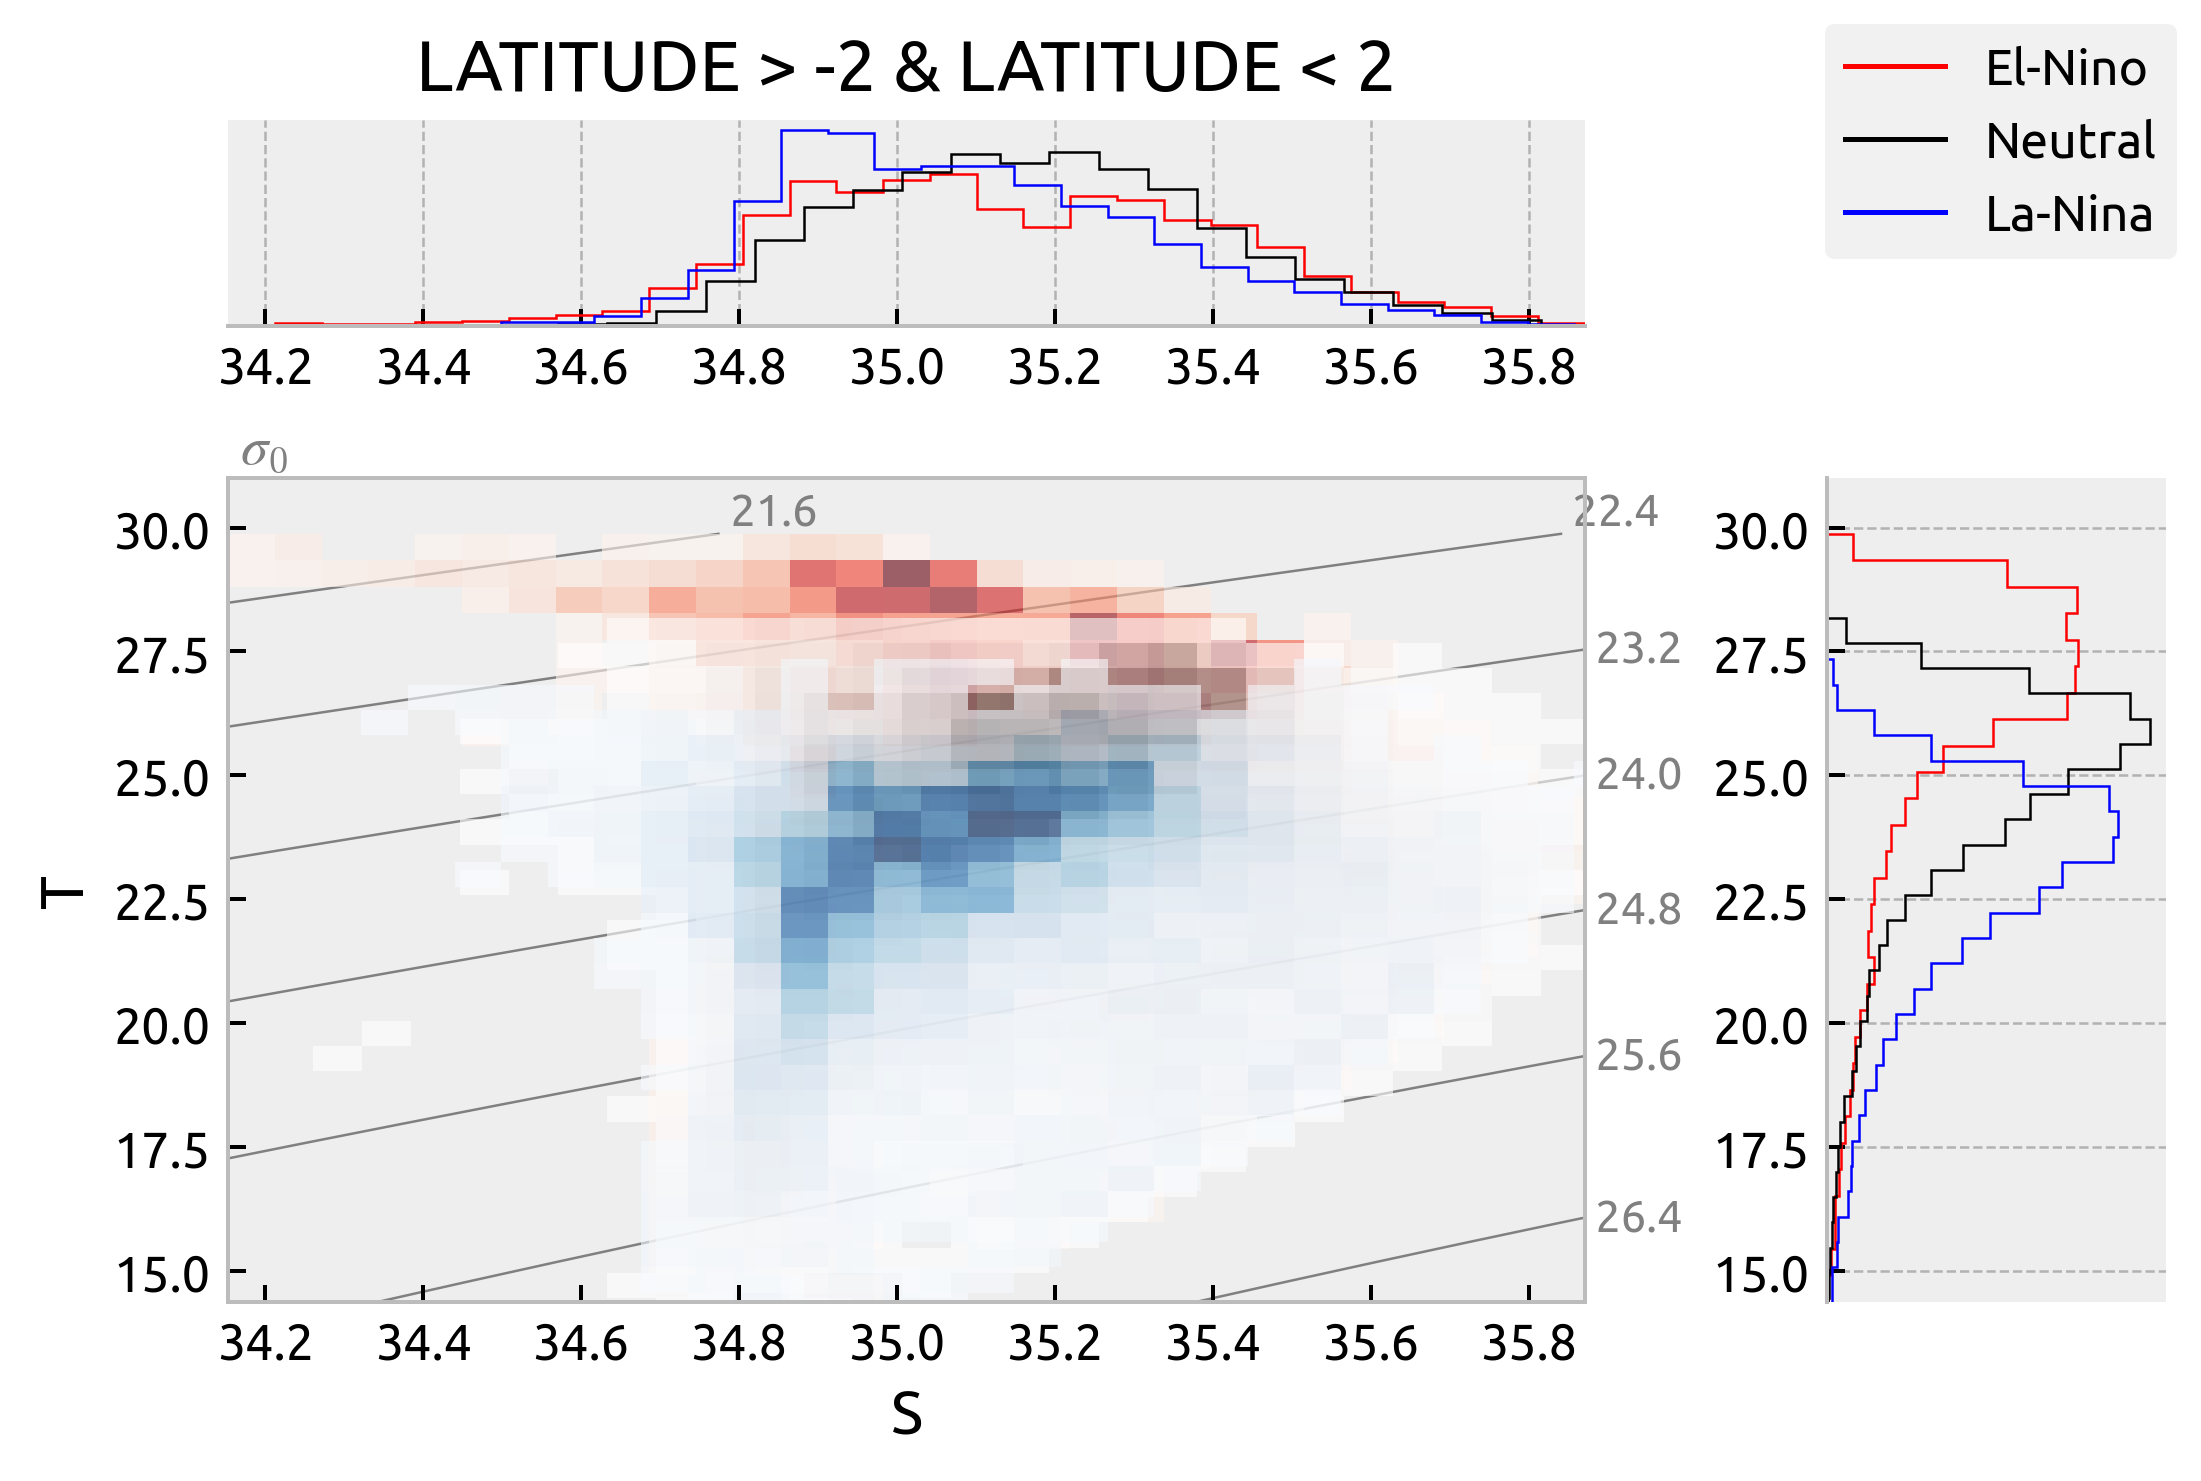

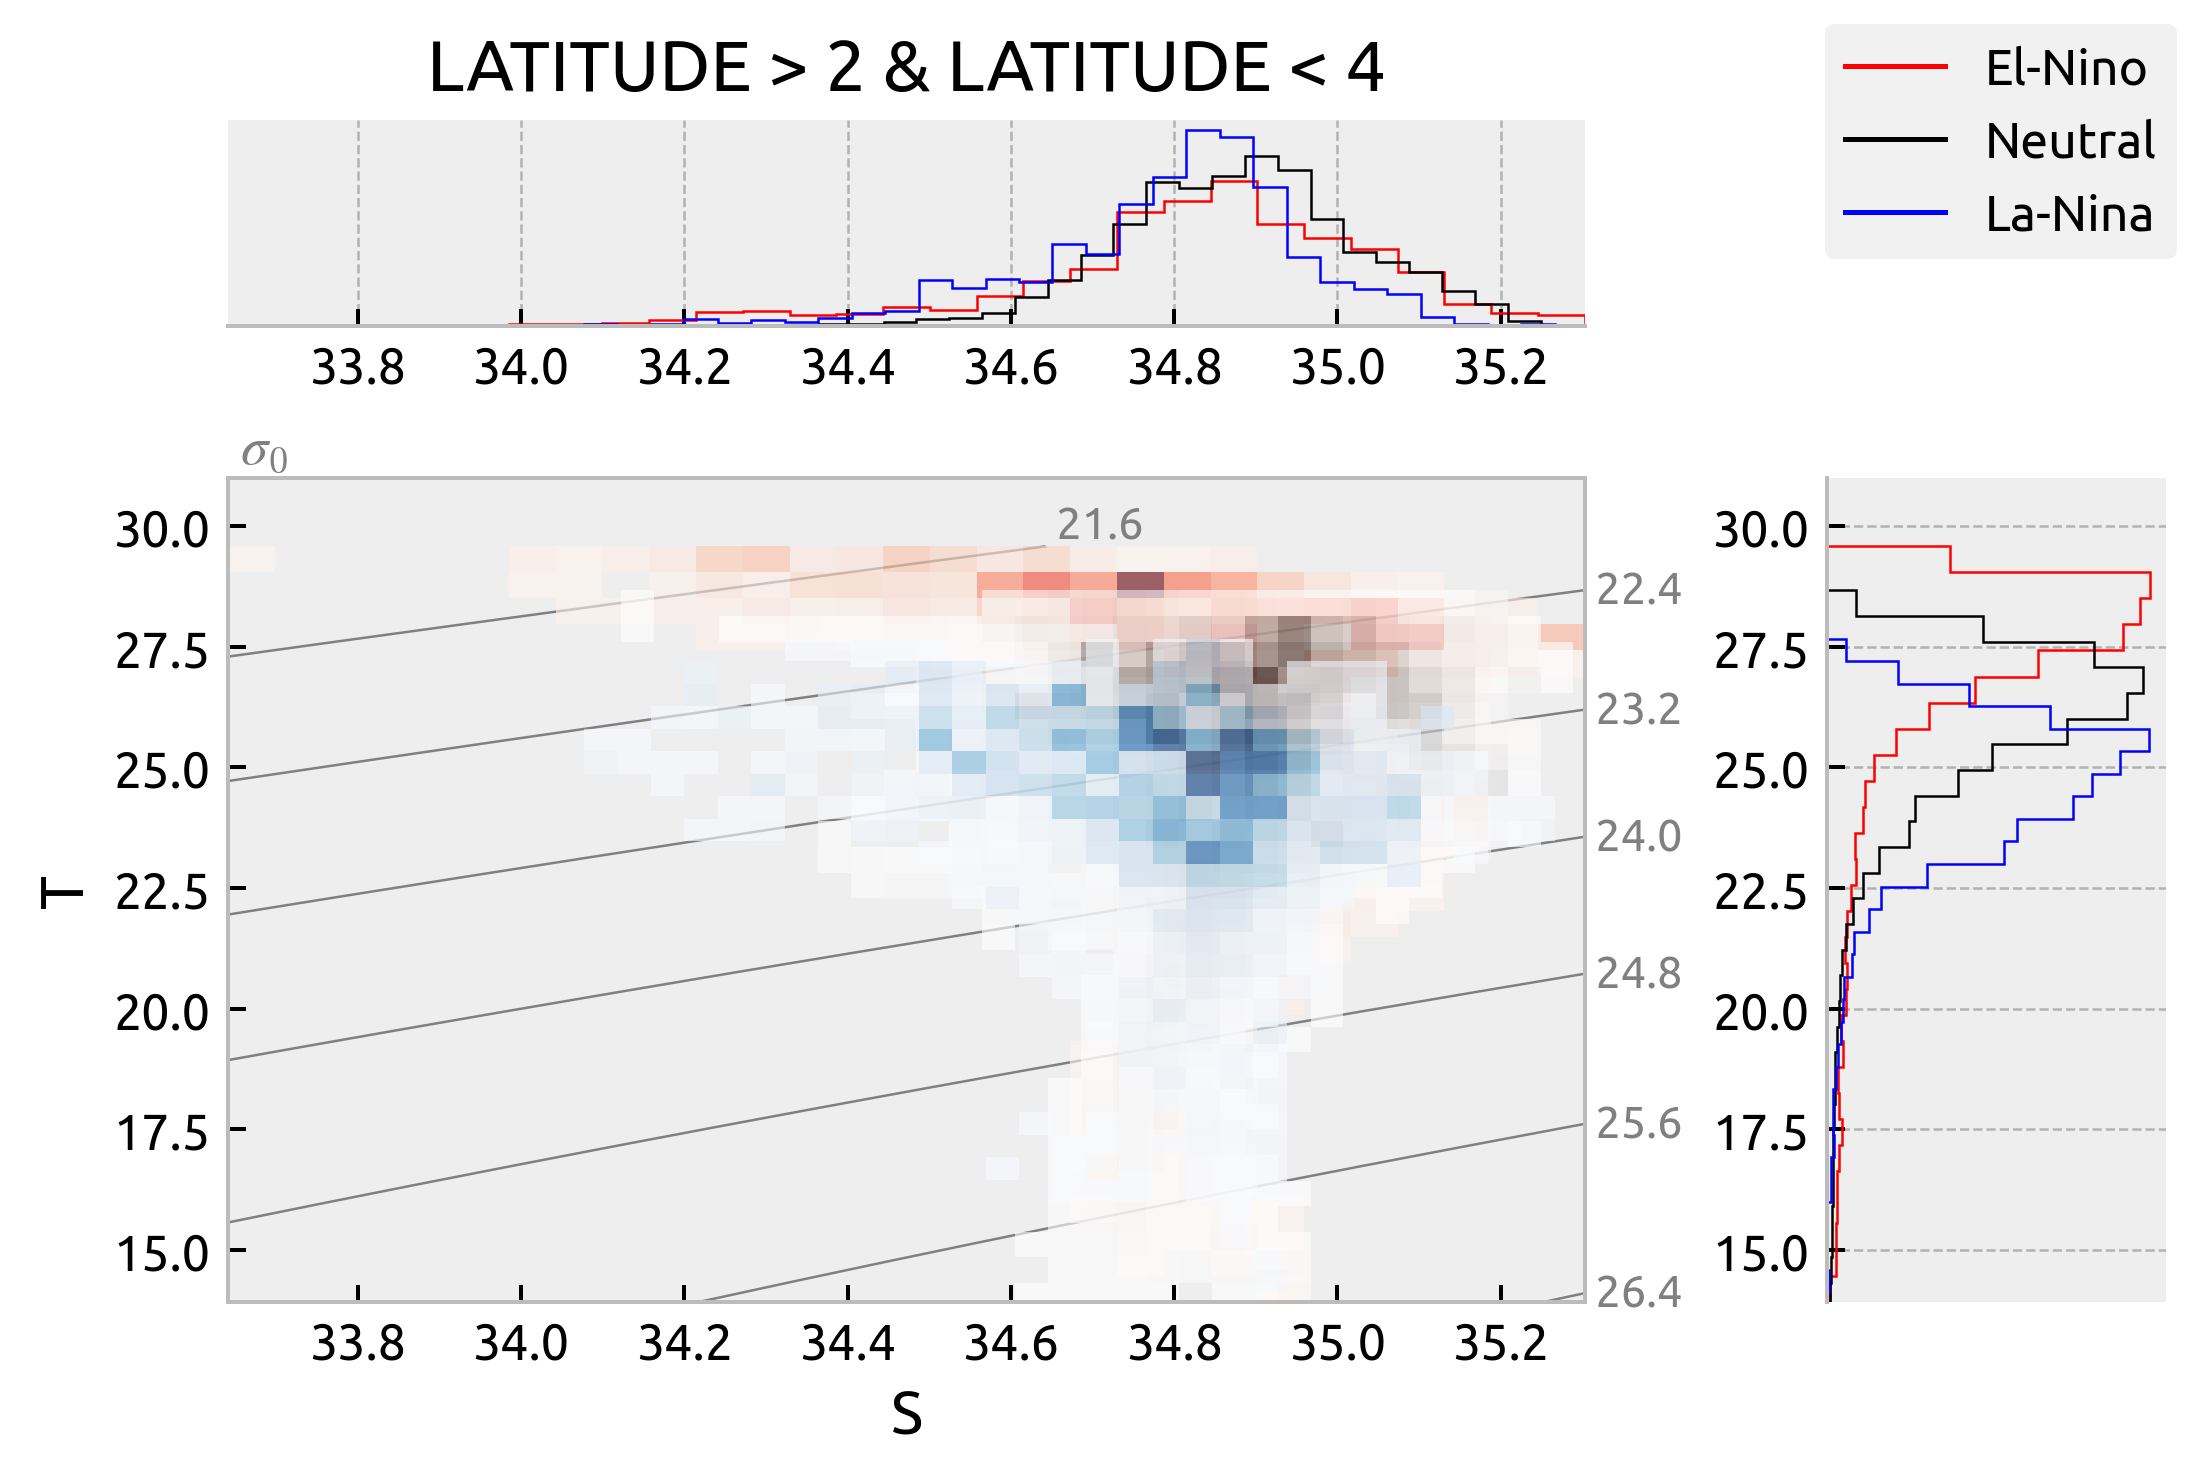

In [34]:
plot_TS(latitude_string="LATITUDE > -2 & LATITUDE < 2")
plot_TS(latitude_string="LATITUDE > 2 & LATITUDE < 4")

---
## Variation of T-S with TIWKE

Looks the same even for weak TIWs

In [28]:
tiwkegrouped = ds.groupby_bins(
    tiwke.sel(time=ds.TIME, method="pad"), bins=[0, 0.025, 0.05, 0.075, 0.2]
)

In [ ]:
from matplotlib.lines import Line2D

ax = None
labels = []
lines = []
for label, group in tiwkegrouped:
    # group = group.query({"N_POINTS": "LONGITUDE < -138 and LONGITUDE > -142"})
    hdl, axxx = dcpy.oceans.TSplot(group.PSAL, group.TEMP, kind="scatter", ax=ax)
    if ax is None:
        ax = axxx
    lines.append(Line2D([0], [0], color=hdl["Thist"][-1][0].get_edgecolor()))
    labels.append(label)

ax["s"].get_figure().legend(lines, labels, title="TIW KE", loc="upper right")

---
## older attempt

I first picked out three years 2008, 2010, 2015-16

In [14]:
ds = xr.open_mfdataset(
    ["argo_140_2008.nc", "argo_140_2010.nc", "argo_140_2016.nc"],
    preprocess=lambda ds: ds.drop_vars("N_POINTS"),
    concat_dim="N_POINTS",
    combine="nested",
)
ds

<xarray.Dataset>
Dimensions:                (N_POINTS: 62174)
Coordinates:
    LATITUDE               (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    LONGITUDE              (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TIME                   (N_POINTS) datetime64[ns] dask.array<chunksize=(8464,), meta=np.ndarray>
Dimensions without coordinates: N_POINTS
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    CYCLE_NUMBER           (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    DATA_MODE              (N_POINTS) object dask.array<chunksize=(8464,), meta=np.ndarray>
    DIRECTION              (N_POINTS) object dask.array<chunksize=(8464,), meta=np.ndarray>
    PLATFORM_NUMBER        (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    POSITION_QC            (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    ...                     ...
    PRES_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    PSAL                   (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    PSAL_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TEMP                   (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TEMP_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TIME_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/04/02
    Fetched_constraints:  [x=-145.00/-135.00; y=-1.00/1.00; z=0.0/500.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [15]:
ds.TIME.dt.year.compute()

<xarray.DataArray 'year' (N_POINTS: 62174)>
array([2008, 2008, 2008, ..., 2016, 2016, 2016])
Coordinates:
    LATITUDE   (N_POINTS) float64 0.707 0.707 0.707 ... -0.202 -0.202 -0.202
    LONGITUDE  (N_POINTS) float64 -136.5 -136.5 -136.5 ... -135.6 -135.6 -135.6
    TIME       (N_POINTS) datetime64[ns] 2008-05-01T16:43:14 ... 2016-04-29T0...
Dimensions without coordinates: N_POINTS

In [18]:
ds.coords["year"] = ds.TIME.dt.year

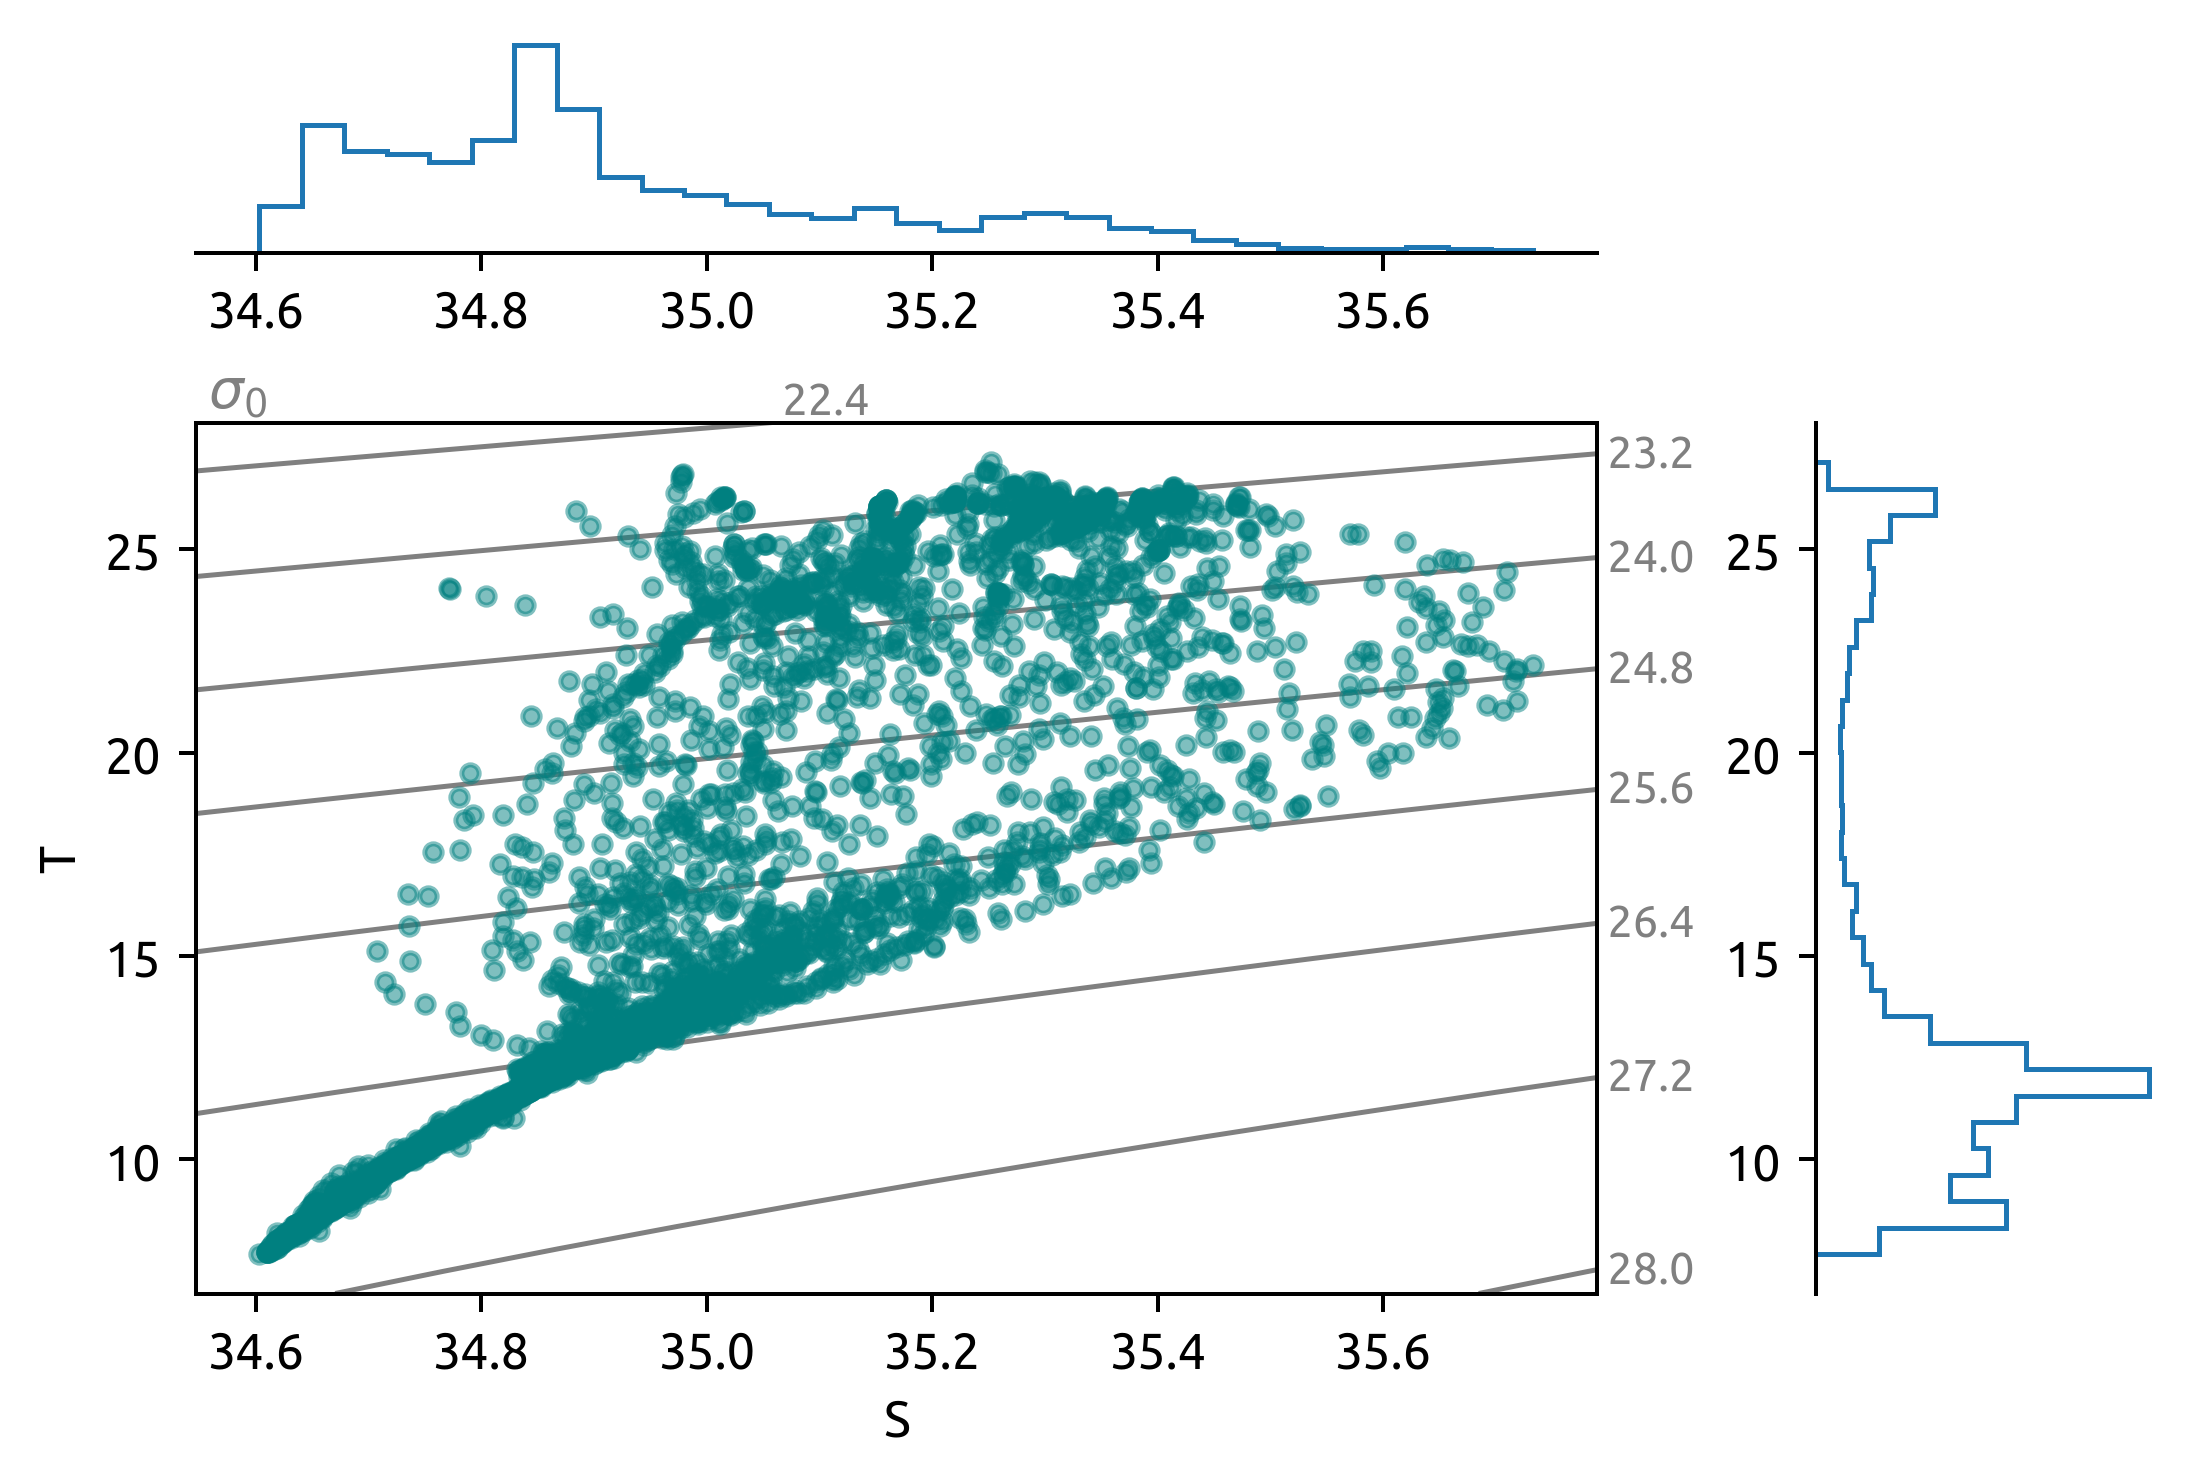

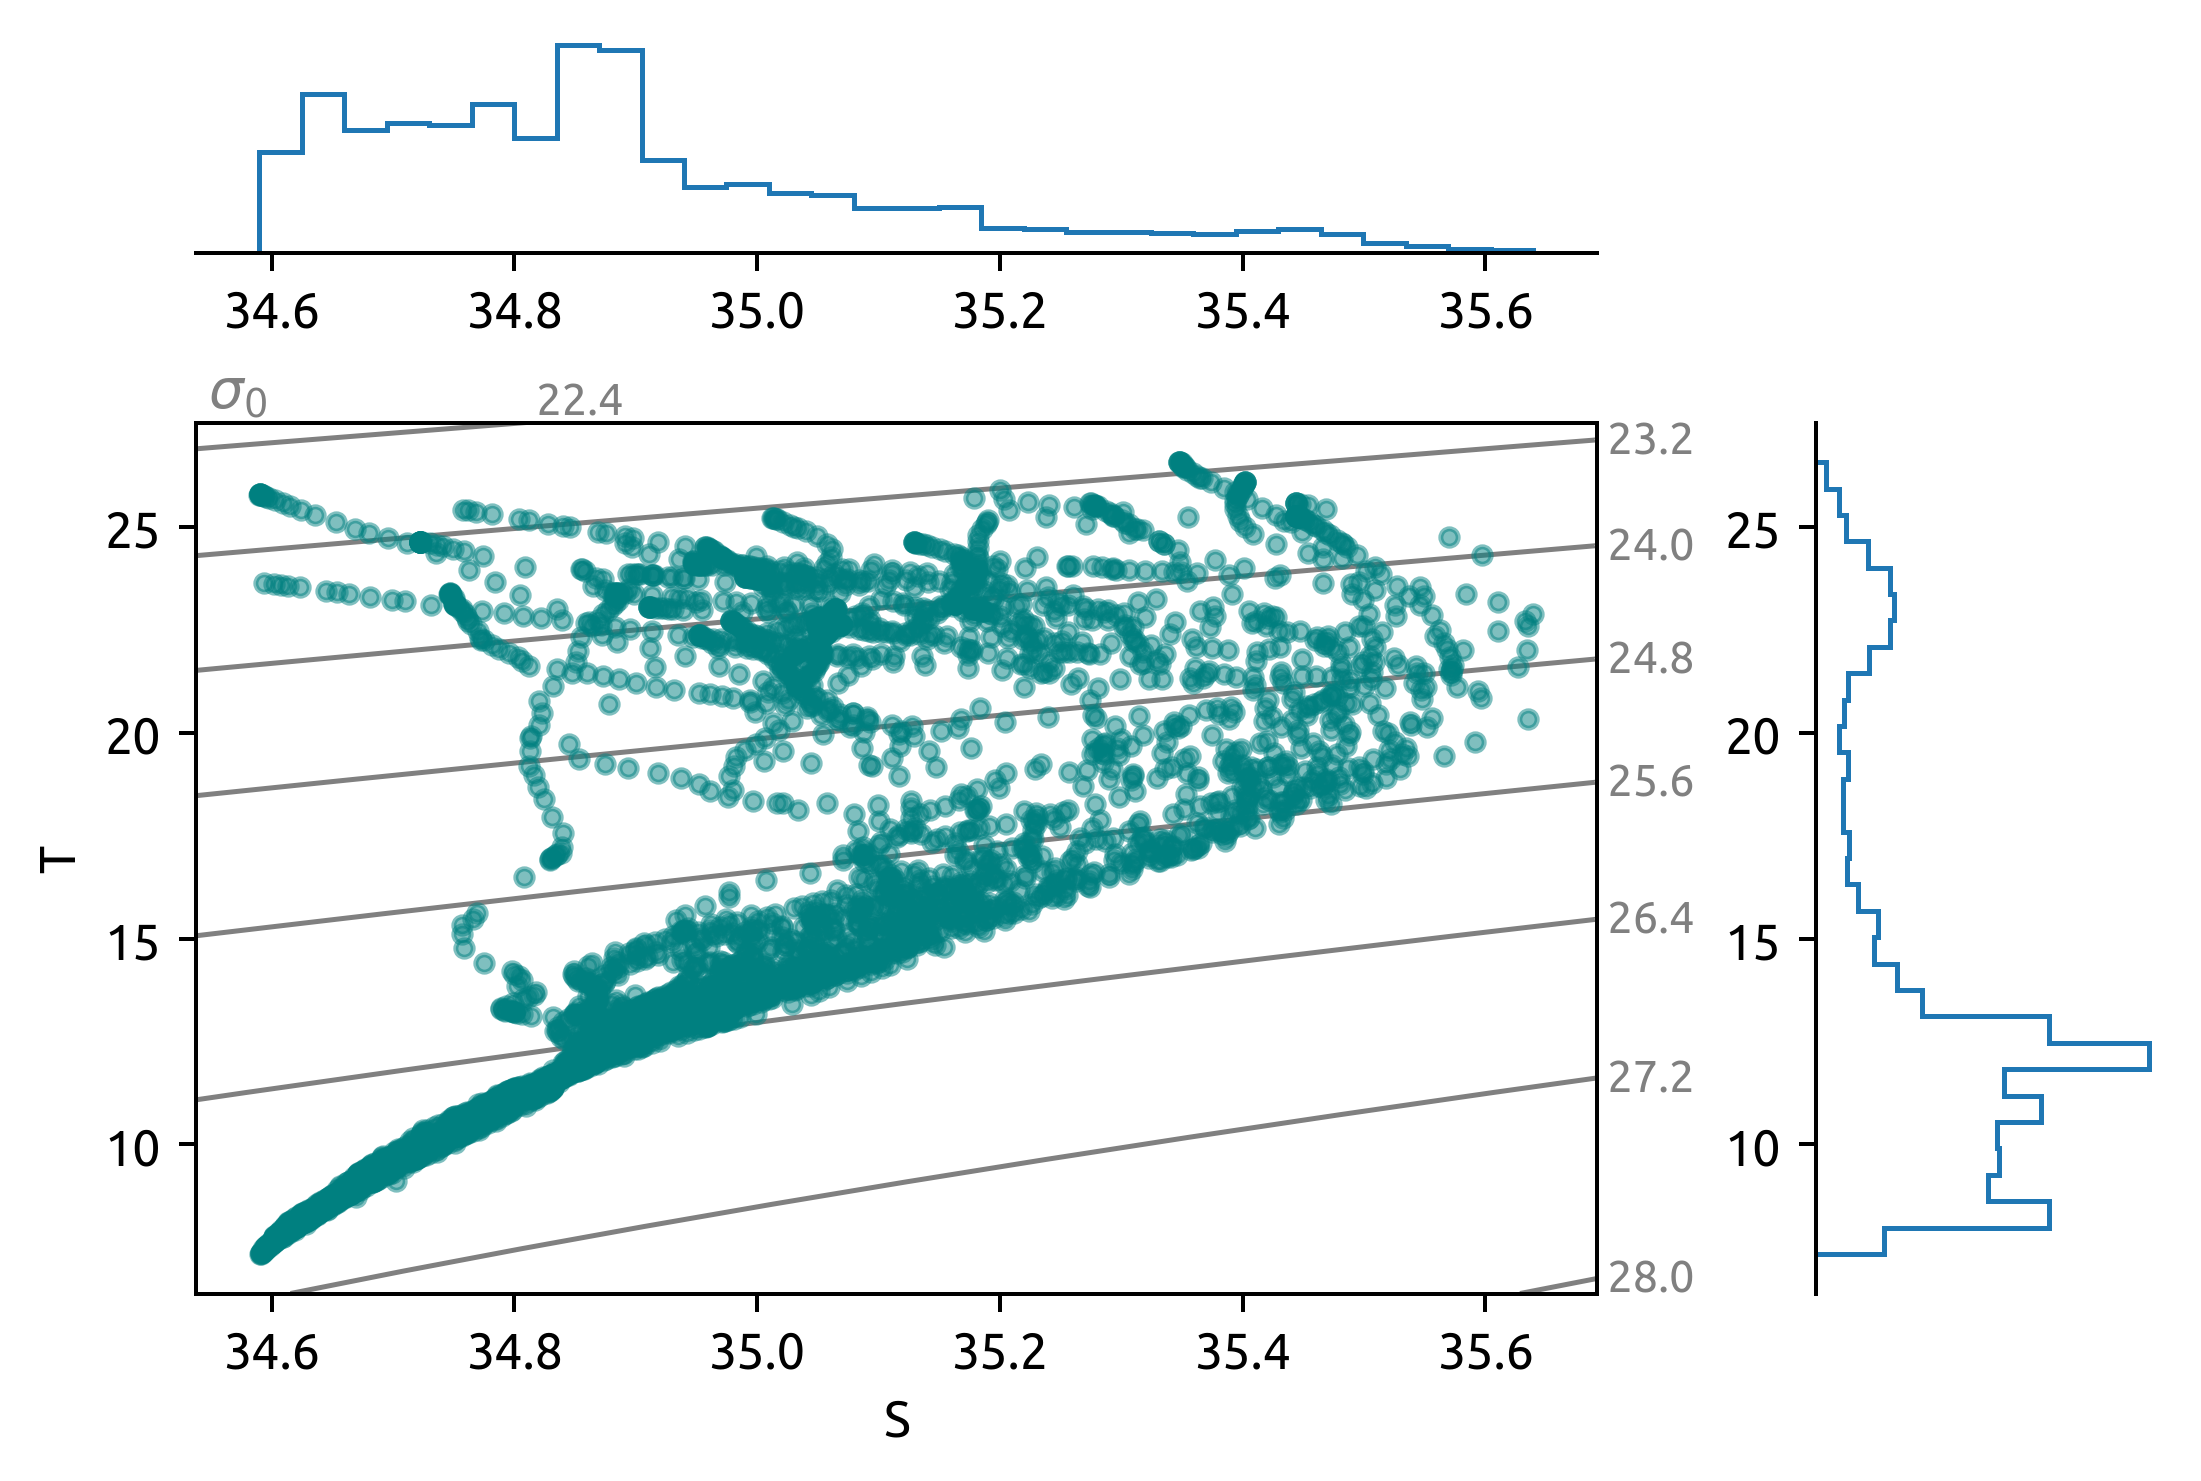

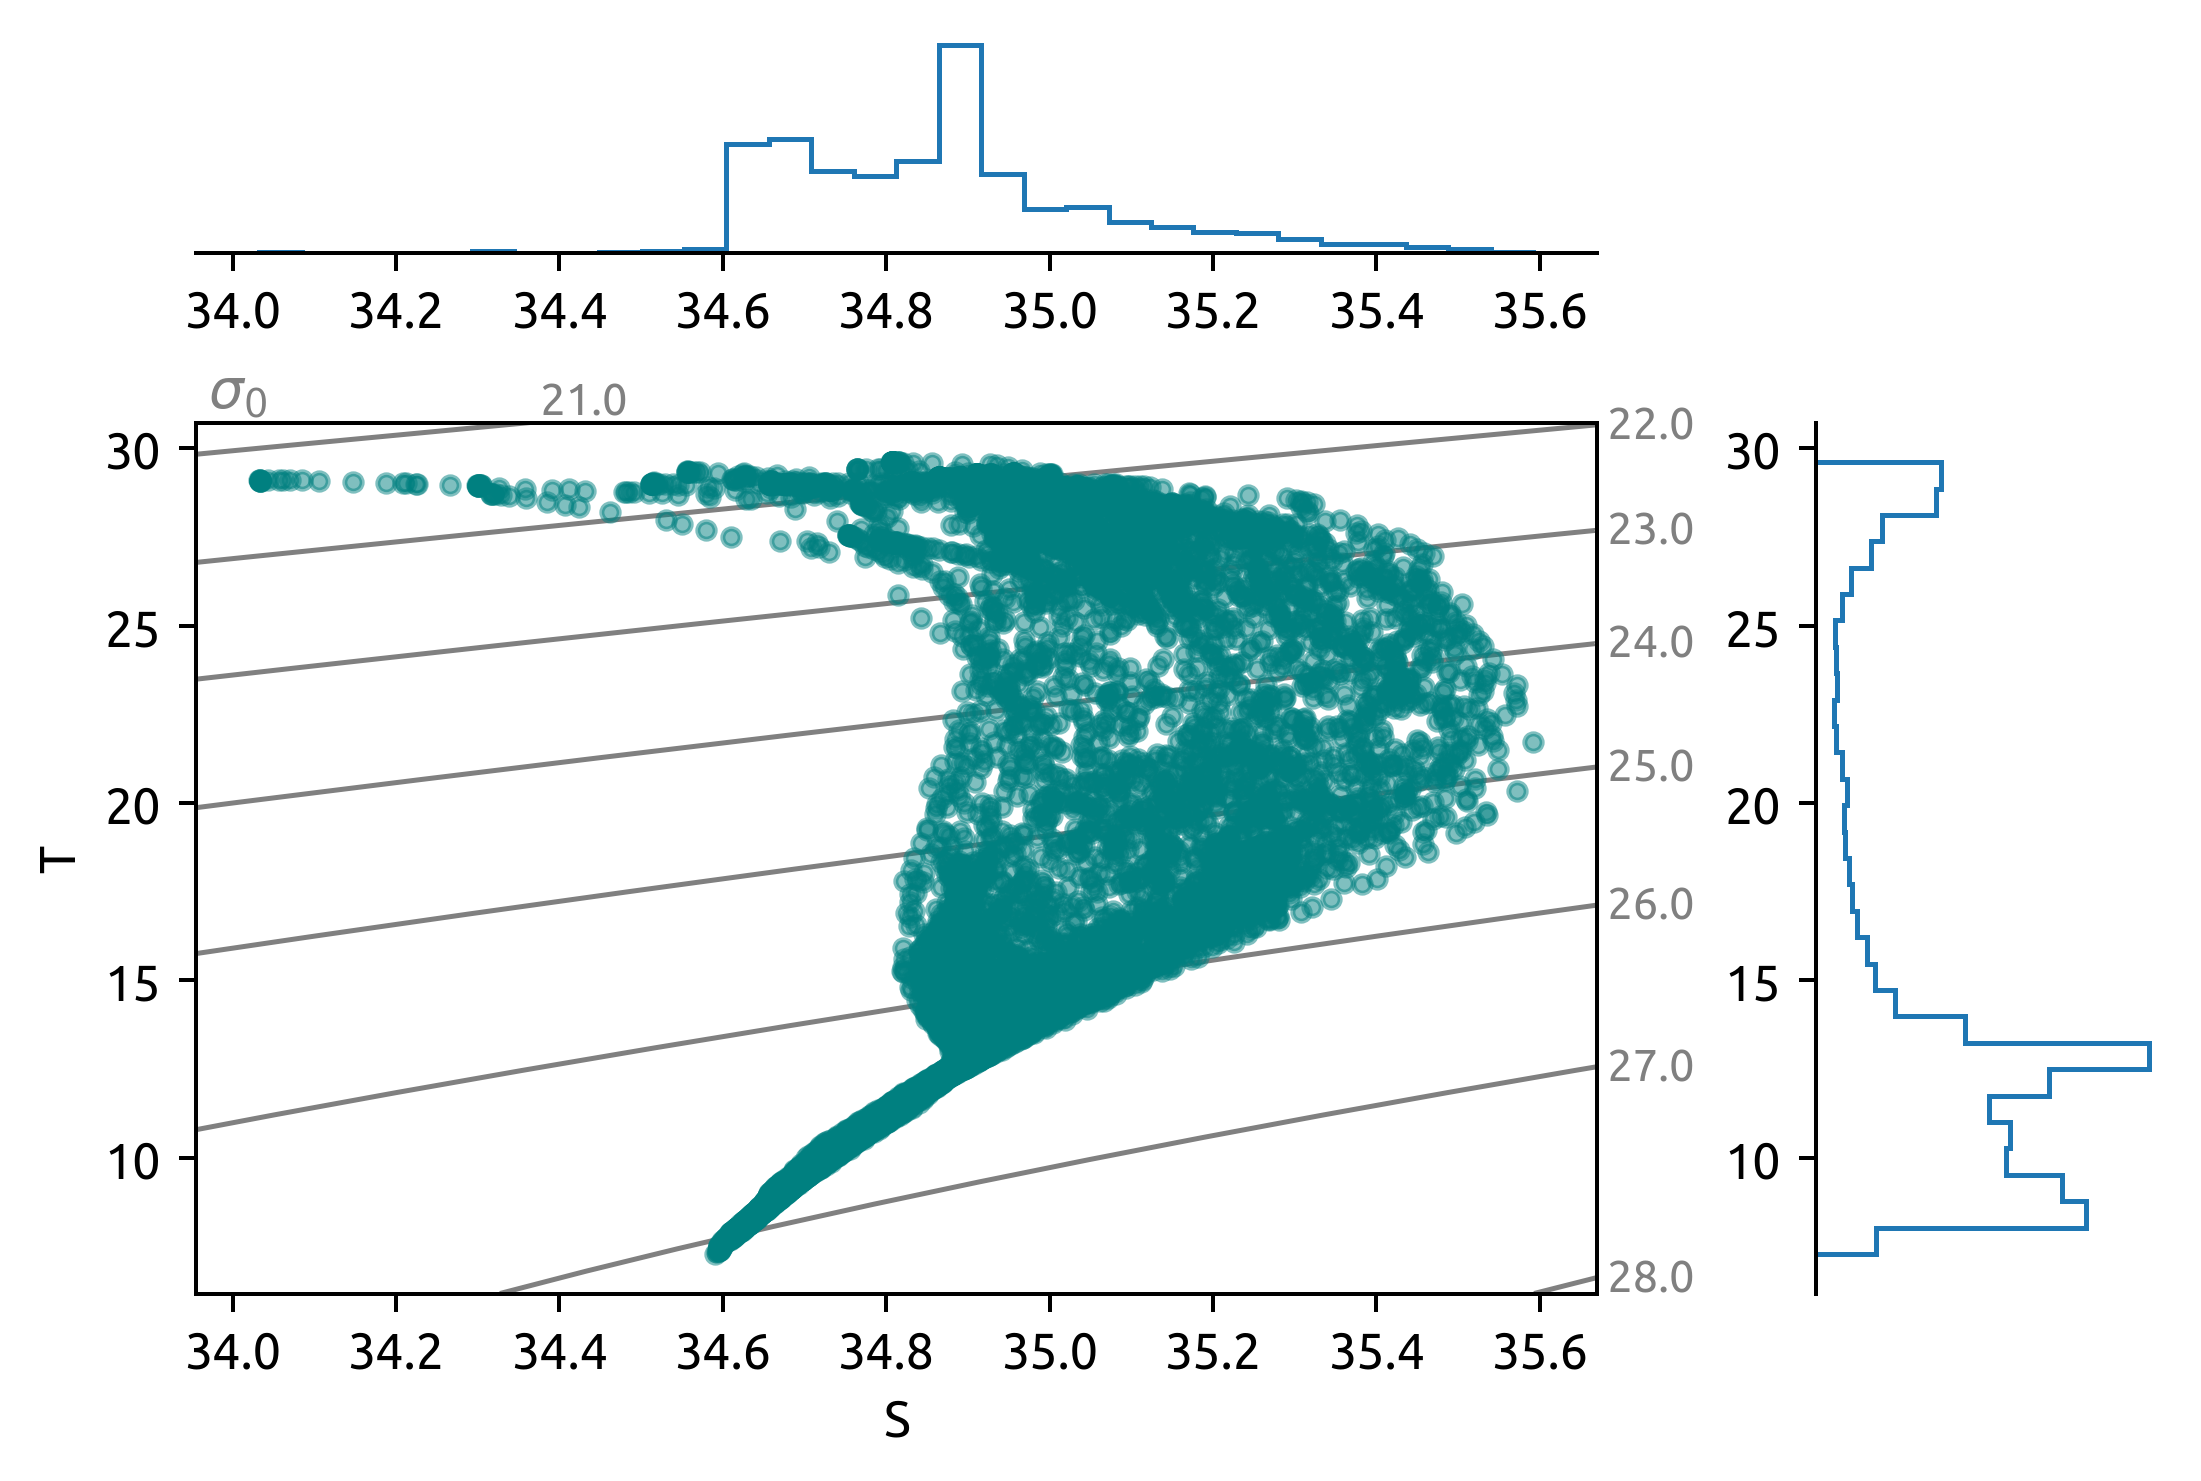

In [28]:
sub = ds.query({"N_POINTS": "year == 2008"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False)

sub = ds.query({"N_POINTS": "year == 2010"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False)


sub = ds.query({"N_POINTS": "year == 2016"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False);

## Download Argo data

In [3]:
from argopy import DataFetcher as ArgoDataFetcher

argo_loader = ArgoDataFetcher()

In [ ]:
ds = argo_loader.region(
    [-145, -135, -2, 8, 0, 500, "2005-01", "2010-12-31"]
).to_xarray()
ds.to_netcdf("argo_140_2005_2010.nc")

In [7]:
ds = argo_loader.region(
    [-145, -135, -2, 8, 0, 500, "2011-01", "2015-12-31"]
).to_xarray()

In [8]:
ds.to_netcdf("argo_140_2011_2015.nc")

In [8]:
# Too much data end up getting HTTP 413: Payload too large errors.
for year in range(2016, 2021):
    ds = argo_loader.region(
        [-145, -135, -2, 8, 0, 500, f"{year}-01-01", f"{year}-12-31"]
    ).to_xarray()
    ds.to_netcdf(f"argo_140_{year}_{year}.nc")

---
## TAO


**Conclusion** There is not enough data. Basically no salinity observations off the equator.

In [3]:
import pump

In [13]:
temp = (
    xr.open_dataset("/home/deepak/TaoTritonPirataRama/TAO_TRITON/t_xyzt_dy.cdf")
    .rename({"T_20": "temp"})
    .cf.guess_coord_axis()
    .sel(lon=220)
)

In [11]:
salt = (
    xr.open_dataset("/home/deepak/TaoTritonPirataRama/TAO_TRITON/s_xyzt_dy.cdf")
    .rename({"S_41": "salt"})
    .cf.guess_coord_axis()
    .sel(lon=220)
)

In [66]:
tao = xr.merge([temp, salt], join="inner").sel(lat=[-5, -2, 0, 2, 5])
tao = tao.where(tao < 1000)

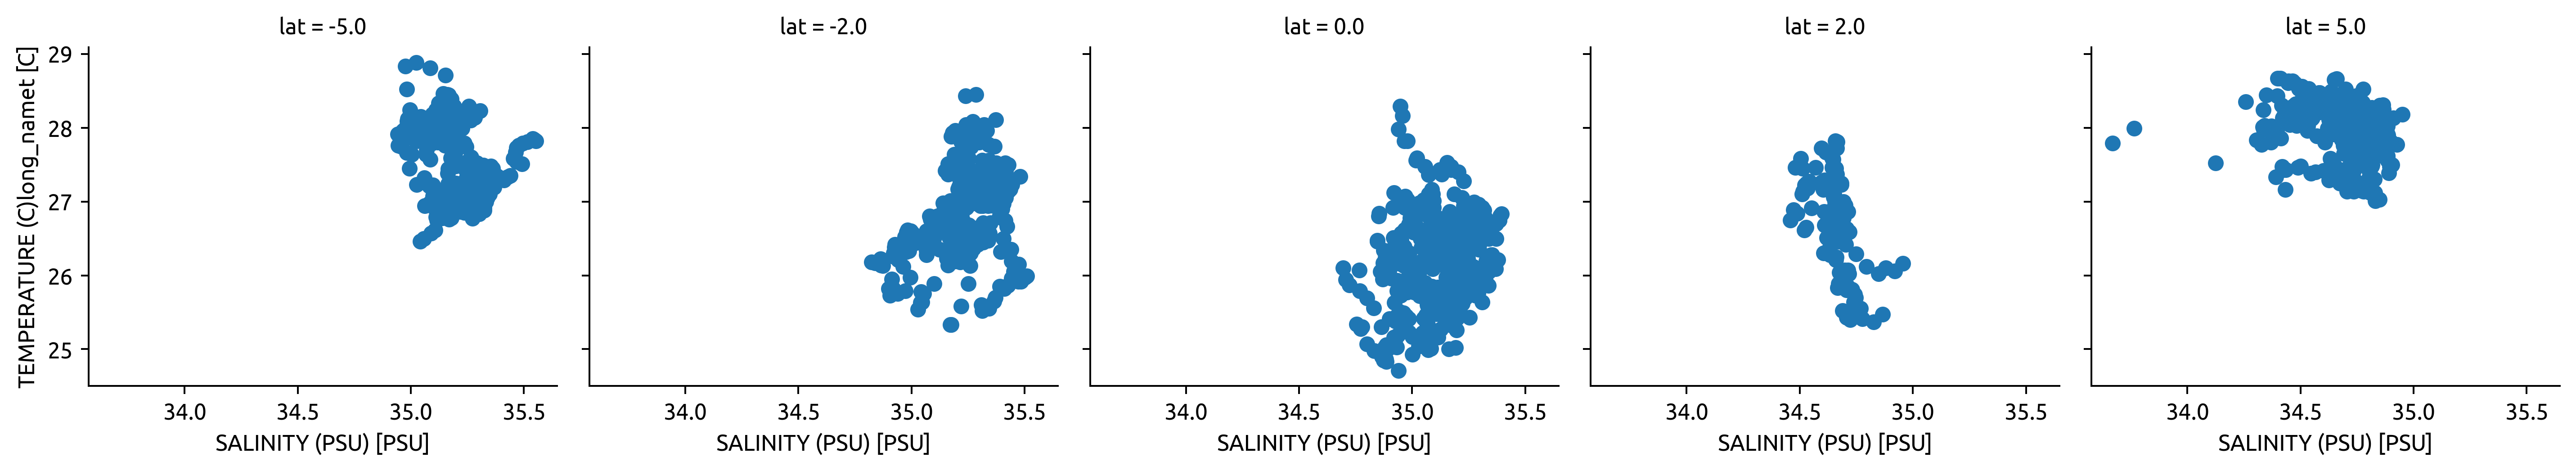

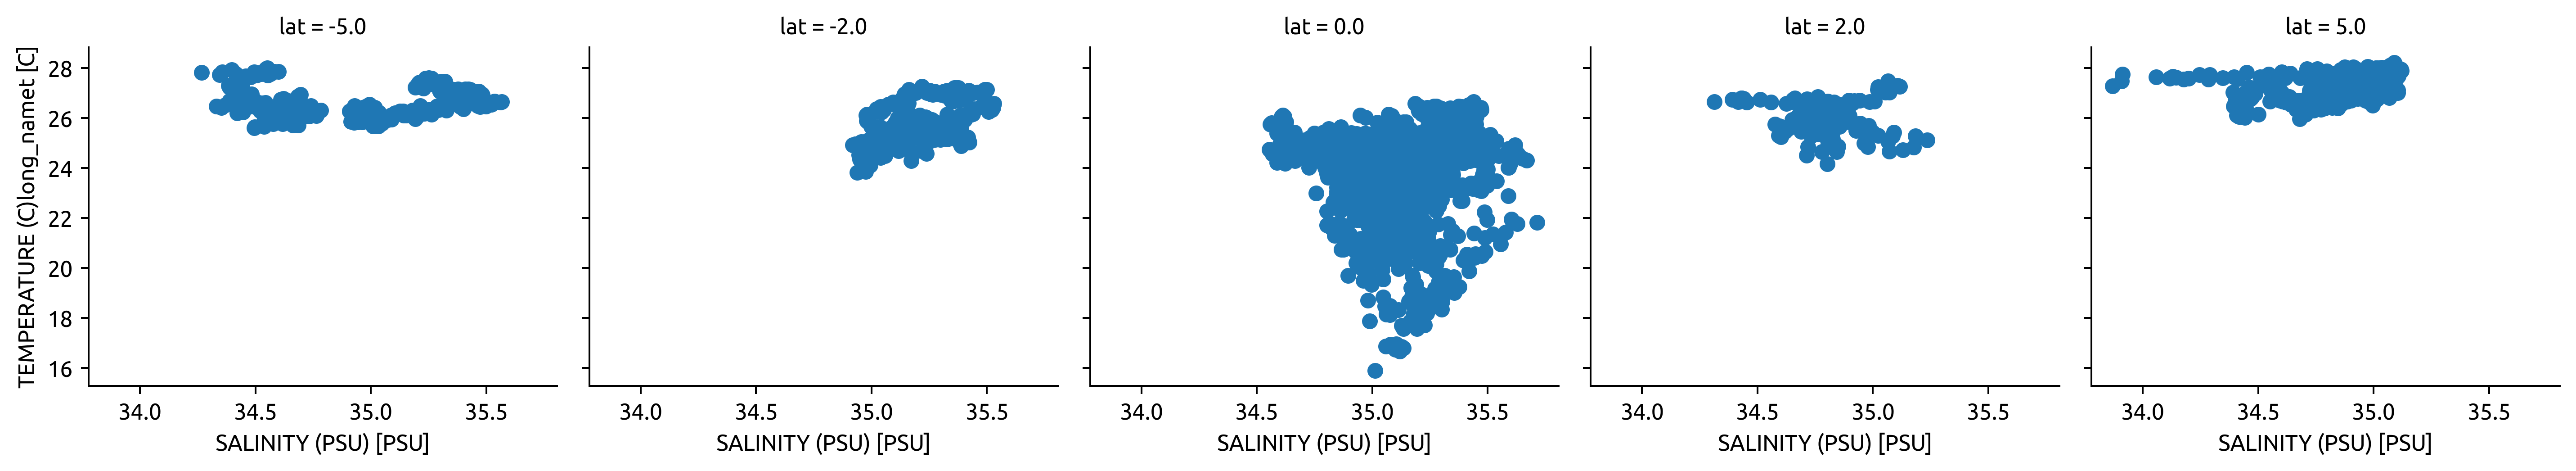

In [58]:
tao.sel(time="2003").plot.scatter("salt", "temp", col="lat")
tao.sel(time=slice("2008-Jun", "2009-Mar")).plot.scatter("salt", "temp", col="lat")